In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

In [2]:
data = pd.read_csv('train2.csv')

In [3]:
stations_nms = list(pd.unique(data["station_nm"]))
ticket_type_nm_list = list(pd.unique(data["ticket_type_nm"]))
line_id_list = list(pd.unique(data["line_id"]))
line_id_list = list(pd.unique(data["entrance_id"]))


ohe = OneHotEncoder(sparse = False)

ohe.fit(data[["station_nm", "ticket_type_nm", "line_id", "entrance_id"]])

ohe_model = ohe.transform(data[["station_nm", "ticket_type_nm", "line_id", "entrance_id"]])

data[ohe.get_feature_names()] = ohe_model

categorical_features = list(ohe.get_feature_names())
station_feature = [feature for feature in categorical_features if feature.startswith("x0")]
ticket_feature = [feature for feature in categorical_features if feature.startswith("x1")]
line_feature = [feature for feature in categorical_features if feature.startswith("x2")]
entrance_to_station_feature = [feature for feature in categorical_features if feature.startswith("x3")]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names()] = ohe_model
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1852155381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [4]:
def get_minutes(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    minutes = dt.hour * 60 + dt.minute
    return(minutes)

def get_hour(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    return dt.hour
    

def get_weekday(date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    return(dt.weekday())


data["entrance_minute"] = data["pass_dttm"].apply(lambda x: get_minutes(x))
data["holiday"] = data["pass_dttm"].apply(lambda x: 0 if get_weekday(x) <= 4 else 1) 
data["weekday"] = data["pass_dttm"].apply(lambda x: get_weekday(x))
data["hour"] = data["pass_dttm"].apply(lambda x: get_hour(x))
data["is_friday"] = data["pass_dttm"].apply(lambda x: 1 if get_weekday(x) == 4 else 0)

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/4124132921.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["entrance_minute"] = data["pass_dttm"].apply(lambda x: get_minutes(x))
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/4124132921.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["holiday"] = data["pass_dttm"].apply(lambda x: 0 if get_weekday(x) <= 4 else 1)
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/4124132921.py:18: PerformanceWarning: DataFrame is

In [5]:
additional_info_for_stations = pd.read_csv(r'/Users/maximvasilev/Desktop/ML/additional_info_for_stations.csv')

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]

data[new_features] = 0

stations_nms = list(pd.unique(data["station_nm"]))
ticket_type_nm_list = list(pd.unique(data["ticket_type_nm"]))
line_id_list = list(pd.unique(data["line_nm"]))


for station in stations_nms:
    
    vals = additional_info_for_stations.loc[additional_info_for_stations["Russian name"] == station, new_features]
    ll = (data.loc[data["station_nm"] == station, new_features]).shape[0]

    
    if len(vals) >= 1:
        data.loc[data["station_nm"] == station, new_features] = pd.DataFrame(list([vals.values[0]])* ll).values
        print(data.loc[data["station_nm"] == station, new_features])
    else:
        data.loc[data["station_nm"] == station, new_features] = pd.DataFrame(np.zeros((ll, 9))).values
        print(data.loc[data["station_nm"] == station, new_features])


/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/3030454821.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[new_features] = 0
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/3030454821.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[new_features] = 0
/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/3030454821.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

         Arts & Entertainment  College & University  Food  Nightlife Spot  \
0                         0.0                   0.0   0.0             0.0   
9062                      0.0                   0.0   0.0             0.0   
13844                     0.0                   0.0   0.0             0.0   
24273                     0.0                   0.0   0.0             0.0   
27945                     0.0                   0.0   0.0             0.0   
...                       ...                   ...   ...             ...   
1090089                   0.0                   0.0   0.0             0.0   
1090223                   0.0                   0.0   0.0             0.0   
1090879                   0.0                   0.0   0.0             0.0   
1090892                   0.0                   0.0   0.0             0.0   
1090972                   0.0                   0.0   0.0             0.0   

         Outdoors & Recreation  Professional & Other Places  Residence  \
0

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
7                    0.022901              0.020833  0.070539         0.02649   
393                  0.022901              0.020833  0.070539         0.02649   
399                  0.022901              0.020833  0.070539         0.02649   
449                  0.022901              0.020833  0.070539         0.02649   
699                  0.022901              0.020833  0.070539         0.02649   
...                       ...                   ...       ...             ...   
1090508              0.022901              0.020833  0.070539         0.02649   
1090525              0.022901              0.020833  0.070539         0.02649   
1090565              0.022901              0.020833  0.070539         0.02649   
1090749              0.022901              0.020833  0.070539         0.02649   
1090780              0.022901              0.020833  0.070539         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
18                   0.030534               0.09375  0.128631        0.033113   
904                  0.030534               0.09375  0.128631        0.033113   
1056                 0.030534               0.09375  0.128631        0.033113   
1072                 0.030534               0.09375  0.128631        0.033113   
1158                 0.030534               0.09375  0.128631        0.033113   
...                       ...                   ...       ...             ...   
1090174              0.030534               0.09375  0.128631        0.033113   
1090297              0.030534               0.09375  0.128631        0.033113   
1090378              0.030534               0.09375  0.128631        0.033113   
1090571              0.030534               0.09375  0.128631        0.033113   
1091006              0.030534               0.09375  0.128631        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
24                   0.038168              0.135417  0.116183         0.02649   
377                  0.038168              0.135417  0.116183         0.02649   
390                  0.038168              0.135417  0.116183         0.02649   
401                  0.038168              0.135417  0.116183         0.02649   
416                  0.038168              0.135417  0.116183         0.02649   
...                       ...                   ...       ...             ...   
1090280              0.038168              0.135417  0.116183         0.02649   
1090820              0.038168              0.135417  0.116183         0.02649   
1090857              0.038168              0.135417  0.116183         0.02649   
1090899              0.038168              0.135417  0.116183         0.02649   
1090904              0.038168              0.135417  0.116183         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
28                   0.358779                   1.0  0.551867        0.192053   
30                   0.358779                   1.0  0.551867        0.192053   
56                   0.358779                   1.0  0.551867        0.192053   
341                  0.358779                   1.0  0.551867        0.192053   
404                  0.358779                   1.0  0.551867        0.192053   
...                       ...                   ...       ...             ...   
1090228              0.358779                   1.0  0.551867        0.192053   
1090375              0.358779                   1.0  0.551867        0.192053   
1090479              0.358779                   1.0  0.551867        0.192053   
1090907              0.358779                   1.0  0.551867        0.192053   
1090973              0.358779                   1.0  0.551867        0.192053   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
35                   0.160305              0.239583  0.282158        0.125828   
1243                 0.160305              0.239583  0.282158        0.125828   
1579                 0.160305              0.239583  0.282158        0.125828   
1615                 0.160305              0.239583  0.282158        0.125828   
1623                 0.160305              0.239583  0.282158        0.125828   
...                       ...                   ...       ...             ...   
1084809              0.160305              0.239583  0.282158        0.125828   
1087663              0.160305              0.239583  0.282158        0.125828   
1089327              0.160305              0.239583  0.282158        0.125828   
1089907              0.160305              0.239583  0.282158        0.125828   
1090822              0.160305              0.239583  0.282158        0.125828   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
40                   0.076336               0.03125  0.012448        0.033113   
42                   0.076336               0.03125  0.012448        0.033113   
50                   0.076336               0.03125  0.012448        0.033113   
82                   0.076336               0.03125  0.012448        0.033113   
116                  0.076336               0.03125  0.012448        0.033113   
...                       ...                   ...       ...             ...   
1090183              0.076336               0.03125  0.012448        0.033113   
1090203              0.076336               0.03125  0.012448        0.033113   
1090472              0.076336               0.03125  0.012448        0.033113   
1090808              0.076336               0.03125  0.012448        0.033113   
1090929              0.076336               0.03125  0.012448        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
52                   0.038168                0.0625  0.107884         0.02649   
155                  0.038168                0.0625  0.107884         0.02649   
218                  0.038168                0.0625  0.107884         0.02649   
1539                 0.038168                0.0625  0.107884         0.02649   
1926                 0.038168                0.0625  0.107884         0.02649   
...                       ...                   ...       ...             ...   
1090316              0.038168                0.0625  0.107884         0.02649   
1090422              0.038168                0.0625  0.107884         0.02649   
1090427              0.038168                0.0625  0.107884         0.02649   
1090875              0.038168                0.0625  0.107884         0.02649   
1090898              0.038168                0.0625  0.107884         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University     Food  Nightlife Spot  \
83                   0.038168              0.041667  0.06639         0.02649   
516                  0.038168              0.041667  0.06639         0.02649   
554                  0.038168              0.041667  0.06639         0.02649   
566                  0.038168              0.041667  0.06639         0.02649   
568                  0.038168              0.041667  0.06639         0.02649   
...                       ...                   ...      ...             ...   
1088893              0.038168              0.041667  0.06639         0.02649   
1090266              0.038168              0.041667  0.06639         0.02649   
1090645              0.038168              0.041667  0.06639         0.02649   
1090716              0.038168              0.041667  0.06639         0.02649   
1090974              0.038168              0.041667  0.06639         0.02649   

         Outdoors & Recreation  Profess

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
95                    0.29771              0.302083  0.327801        0.145695   
381                   0.29771              0.302083  0.327801        0.145695   
460                   0.29771              0.302083  0.327801        0.145695   
674                   0.29771              0.302083  0.327801        0.145695   
778                   0.29771              0.302083  0.327801        0.145695   
...                       ...                   ...       ...             ...   
1090539               0.29771              0.302083  0.327801        0.145695   
1090637               0.29771              0.302083  0.327801        0.145695   
1090768               0.29771              0.302083  0.327801        0.145695   
1090920               0.29771              0.302083  0.327801        0.145695   
1090947               0.29771              0.302083  0.327801        0.145695   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
105                  0.022901              0.041667  0.053942         0.05298   
110                  0.022901              0.041667  0.053942         0.05298   
112                  0.022901              0.041667  0.053942         0.05298   
115                  0.022901              0.041667  0.053942         0.05298   
117                  0.022901              0.041667  0.053942         0.05298   
...                       ...                   ...       ...             ...   
1090459              0.022901              0.041667  0.053942         0.05298   
1090465              0.022901              0.041667  0.053942         0.05298   
1090489              0.022901              0.041667  0.053942         0.05298   
1090589              0.022901              0.041667  0.053942         0.05298   
1090937              0.022901              0.041667  0.053942         0.05298   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
125                  0.061069               0.15625  0.082988        0.033113   
156                  0.061069               0.15625  0.082988        0.033113   
168                  0.061069               0.15625  0.082988        0.033113   
1622                 0.061069               0.15625  0.082988        0.033113   
1749                 0.061069               0.15625  0.082988        0.033113   
...                       ...                   ...       ...             ...   
1090124              0.061069               0.15625  0.082988        0.033113   
1090332              0.061069               0.15625  0.082988        0.033113   
1090829              0.061069               0.15625  0.082988        0.033113   
1090932              0.061069               0.15625  0.082988        0.033113   
1090933              0.061069               0.15625  0.082988        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
143                  0.122137              0.354167  0.186722        0.066225   
158                  0.122137              0.354167  0.186722        0.066225   
162                  0.122137              0.354167  0.186722        0.066225   
169                  0.122137              0.354167  0.186722        0.066225   
179                  0.122137              0.354167  0.186722        0.066225   
...                       ...                   ...       ...             ...   
1090418              0.122137              0.354167  0.186722        0.066225   
1090654              0.122137              0.354167  0.186722        0.066225   
1090680              0.122137              0.354167  0.186722        0.066225   
1090770              0.122137              0.354167  0.186722        0.066225   
1090771              0.122137              0.354167  0.186722        0.066225   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
171                  0.015267              0.020833  0.033195         0.02649   
1191                 0.015267              0.020833  0.033195         0.02649   
2771                 0.015267              0.020833  0.033195         0.02649   
4178                 0.015267              0.020833  0.033195         0.02649   
7671                 0.015267              0.020833  0.033195         0.02649   
...                       ...                   ...       ...             ...   
1089696              0.015267              0.020833  0.033195         0.02649   
1089772              0.015267              0.020833  0.033195         0.02649   
1090347              0.015267              0.020833  0.033195         0.02649   
1090354              0.015267              0.020833  0.033195         0.02649   
1090448              0.015267              0.020833  0.033195         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
208                  0.038168              0.072917  0.033195        0.039735   
344                  0.038168              0.072917  0.033195        0.039735   
353                  0.038168              0.072917  0.033195        0.039735   
355                  0.038168              0.072917  0.033195        0.039735   
370                  0.038168              0.072917  0.033195        0.039735   
...                       ...                   ...       ...             ...   
1090334              0.038168              0.072917  0.033195        0.039735   
1090436              0.038168              0.072917  0.033195        0.039735   
1090526              0.038168              0.072917  0.033195        0.039735   
1090564              0.038168              0.072917  0.033195        0.039735   
1090726              0.038168              0.072917  0.033195        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
215                  0.381679                0.6875  0.564315        0.284768   
230                  0.381679                0.6875  0.564315        0.284768   
249                  0.381679                0.6875  0.564315        0.284768   
264                  0.381679                0.6875  0.564315        0.284768   
266                  0.381679                0.6875  0.564315        0.284768   
...                       ...                   ...       ...             ...   
1090376              0.381679                0.6875  0.564315        0.284768   
1090613              0.381679                0.6875  0.564315        0.284768   
1090761              0.381679                0.6875  0.564315        0.284768   
1090799              0.381679                0.6875  0.564315        0.284768   
1090931              0.381679                0.6875  0.564315        0.284768   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
240                  0.030534               0.03125  0.095436        0.046358   
248                  0.030534               0.03125  0.095436        0.046358   
710                  0.030534               0.03125  0.095436        0.046358   
724                  0.030534               0.03125  0.095436        0.046358   
1049                 0.030534               0.03125  0.095436        0.046358   
...                       ...                   ...       ...             ...   
1090658              0.030534               0.03125  0.095436        0.046358   
1090744              0.030534               0.03125  0.095436        0.046358   
1090778              0.030534               0.03125  0.095436        0.046358   
1090825              0.030534               0.03125  0.095436        0.046358   
1090852              0.030534               0.03125  0.095436        0.046358   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
261                  0.091603                 0.125  0.128631         0.02649   
282                  0.091603                 0.125  0.128631         0.02649   
287                  0.091603                 0.125  0.128631         0.02649   
288                  0.091603                 0.125  0.128631         0.02649   
292                  0.091603                 0.125  0.128631         0.02649   
...                       ...                   ...       ...             ...   
1090560              0.091603                 0.125  0.128631         0.02649   
1090729              0.091603                 0.125  0.128631         0.02649   
1090790              0.091603                 0.125  0.128631         0.02649   
1090876              0.091603                 0.125  0.128631         0.02649   
1091008              0.091603                 0.125  0.128631         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
285                  0.061069                 0.125  0.174274         0.05298   
494                  0.061069                 0.125  0.174274         0.05298   
522                  0.061069                 0.125  0.174274         0.05298   
543                  0.061069                 0.125  0.174274         0.05298   
614                  0.061069                 0.125  0.174274         0.05298   
...                       ...                   ...       ...             ...   
1090662              0.061069                 0.125  0.174274         0.05298   
1090666              0.061069                 0.125  0.174274         0.05298   
1090751              0.061069                 0.125  0.174274         0.05298   
1090897              0.061069                 0.125  0.174274         0.05298   
1090967              0.061069                 0.125  0.174274         0.05298   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
293                  0.045802              0.083333  0.087137         0.05298   
305                  0.045802              0.083333  0.087137         0.05298   
316                  0.045802              0.083333  0.087137         0.05298   
325                  0.045802              0.083333  0.087137         0.05298   
369                  0.045802              0.083333  0.087137         0.05298   
...                       ...                   ...       ...             ...   
1090303              0.045802              0.083333  0.087137         0.05298   
1090356              0.045802              0.083333  0.087137         0.05298   
1090576              0.045802              0.083333  0.087137         0.05298   
1090791              0.045802              0.083333  0.087137         0.05298   
1090815              0.045802              0.083333  0.087137         0.05298   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
308                  0.152672                 0.375  0.145228         0.07947   
324                  0.152672                 0.375  0.145228         0.07947   
368                  0.152672                 0.375  0.145228         0.07947   
747                  0.152672                 0.375  0.145228         0.07947   
1970                 0.152672                 0.375  0.145228         0.07947   
...                       ...                   ...       ...             ...   
1089464              0.152672                 0.375  0.145228         0.07947   
1089808              0.152672                 0.375  0.145228         0.07947   
1090239              0.152672                 0.375  0.145228         0.07947   
1090359              0.152672                 0.375  0.145228         0.07947   
1090372              0.152672                 0.375  0.145228         0.07947   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
321                  0.007634                   0.0  0.016598        0.019868   
343                  0.007634                   0.0  0.016598        0.019868   
349                  0.007634                   0.0  0.016598        0.019868   
364                  0.007634                   0.0  0.016598        0.019868   
375                  0.007634                   0.0  0.016598        0.019868   
...                       ...                   ...       ...             ...   
1090641              0.007634                   0.0  0.016598        0.019868   
1090700              0.007634                   0.0  0.016598        0.019868   
1090786              0.007634                   0.0  0.016598        0.019868   
1090831              0.007634                   0.0  0.016598        0.019868   
1090945              0.007634                   0.0  0.016598        0.019868   

         Outdoors & Recreat

         Arts & Entertainment  College & University  Food  Nightlife Spot  \
334                       0.0                   0.0   0.0             0.0   
337                       0.0                   0.0   0.0             0.0   
423                       0.0                   0.0   0.0             0.0   
524                       0.0                   0.0   0.0             0.0   
679                       0.0                   0.0   0.0             0.0   
...                       ...                   ...   ...             ...   
1090323                   0.0                   0.0   0.0             0.0   
1090395                   0.0                   0.0   0.0             0.0   
1090516                   0.0                   0.0   0.0             0.0   
1090871                   0.0                   0.0   0.0             0.0   
1091002                   0.0                   0.0   0.0             0.0   

         Outdoors & Recreation  Professional & Other Places  Residence  \
3

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
351                  0.038168               0.15625  0.116183        0.039735   
415                  0.038168               0.15625  0.116183        0.039735   
433                  0.038168               0.15625  0.116183        0.039735   
451                  0.038168               0.15625  0.116183        0.039735   
466                  0.038168               0.15625  0.116183        0.039735   
...                       ...                   ...       ...             ...   
1089979              0.038168               0.15625  0.116183        0.039735   
1090039              0.038168               0.15625  0.116183        0.039735   
1090381              0.038168               0.15625  0.116183        0.039735   
1090462              0.038168               0.15625  0.116183        0.039735   
1090484              0.038168               0.15625  0.116183        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
367                   0.19084              0.083333  0.211618        0.092715   
413                   0.19084              0.083333  0.211618        0.092715   
420                   0.19084              0.083333  0.211618        0.092715   
426                   0.19084              0.083333  0.211618        0.092715   
452                   0.19084              0.083333  0.211618        0.092715   
...                       ...                   ...       ...             ...   
1087890               0.19084              0.083333  0.211618        0.092715   
1088928               0.19084              0.083333  0.211618        0.092715   
1090597               0.19084              0.083333  0.211618        0.092715   
1090678               0.19084              0.083333  0.211618        0.092715   
1090861               0.19084              0.083333  0.211618        0.092715   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
395                  0.061069              0.197917  0.058091        0.033113   
428                  0.061069              0.197917  0.058091        0.033113   
624                  0.061069              0.197917  0.058091        0.033113   
934                  0.061069              0.197917  0.058091        0.033113   
1235                 0.061069              0.197917  0.058091        0.033113   
...                       ...                   ...       ...             ...   
1089889              0.061069              0.197917  0.058091        0.033113   
1090243              0.061069              0.197917  0.058091        0.033113   
1090391              0.061069              0.197917  0.058091        0.033113   
1090686              0.061069              0.197917  0.058091        0.033113   
1090741              0.061069              0.197917  0.058091        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
409                  0.038168              0.072917  0.091286        0.039735   
422                  0.038168              0.072917  0.091286        0.039735   
1023                 0.038168              0.072917  0.091286        0.039735   
1068                 0.038168              0.072917  0.091286        0.039735   
1254                 0.038168              0.072917  0.091286        0.039735   
...                       ...                   ...       ...             ...   
1089556              0.038168              0.072917  0.091286        0.039735   
1089559              0.038168              0.072917  0.091286        0.039735   
1090009              0.038168              0.072917  0.091286        0.039735   
1090259              0.038168              0.072917  0.091286        0.039735   
1090797              0.038168              0.072917  0.091286        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
446                   0.10687              0.322917  0.248963         0.07947   
536                   0.10687              0.322917  0.248963         0.07947   
2154                  0.10687              0.322917  0.248963         0.07947   
5944                  0.10687              0.322917  0.248963         0.07947   
7332                  0.10687              0.322917  0.248963         0.07947   
...                       ...                   ...       ...             ...   
1089278               0.10687              0.322917  0.248963         0.07947   
1089881               0.10687              0.322917  0.248963         0.07947   
1090123               0.10687              0.322917  0.248963         0.07947   
1090675               0.10687              0.322917  0.248963         0.07947   
1090938               0.10687              0.322917  0.248963         0.07947   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
470                  0.114504              0.333333  0.174274        0.046358   
740                  0.114504              0.333333  0.174274        0.046358   
742                  0.114504              0.333333  0.174274        0.046358   
844                  0.114504              0.333333  0.174274        0.046358   
1362                 0.114504              0.333333  0.174274        0.046358   
...                       ...                   ...       ...             ...   
1089202              0.114504              0.333333  0.174274        0.046358   
1089687              0.114504              0.333333  0.174274        0.046358   
1089860              0.114504              0.333333  0.174274        0.046358   
1090537              0.114504              0.333333  0.174274        0.046358   
1090841              0.114504              0.333333  0.174274        0.046358   

         Outdoors & Recreat

         Arts & Entertainment  College & University  Food  Nightlife Spot  \
482                       0.0                   0.0   0.0             0.0   
593                       0.0                   0.0   0.0             0.0   
1125                      0.0                   0.0   0.0             0.0   
1315                      0.0                   0.0   0.0             0.0   
1489                      0.0                   0.0   0.0             0.0   
...                       ...                   ...   ...             ...   
1087069                   0.0                   0.0   0.0             0.0   
1087745                   0.0                   0.0   0.0             0.0   
1089053                   0.0                   0.0   0.0             0.0   
1089516                   0.0                   0.0   0.0             0.0   
1091014                   0.0                   0.0   0.0             0.0   

         Outdoors & Recreation  Professional & Other Places  Residence  \
4

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
504                  0.091603              0.822917  0.170124         0.02649   
896                  0.091603              0.822917  0.170124         0.02649   
1538                 0.091603              0.822917  0.170124         0.02649   
2256                 0.091603              0.822917  0.170124         0.02649   
2621                 0.091603              0.822917  0.170124         0.02649   
...                       ...                   ...       ...             ...   
1089156              0.091603              0.822917  0.170124         0.02649   
1089179              0.091603              0.822917  0.170124         0.02649   
1089410              0.091603              0.822917  0.170124         0.02649   
1089999              0.091603              0.822917  0.170124         0.02649   
1090346              0.091603              0.822917  0.170124         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
535                  0.114504              0.135417  0.124481        0.059603   
703                  0.114504              0.135417  0.124481        0.059603   
1281                 0.114504              0.135417  0.124481        0.059603   
1667                 0.114504              0.135417  0.124481        0.059603   
1854                 0.114504              0.135417  0.124481        0.059603   
...                       ...                   ...       ...             ...   
1090292              0.114504              0.135417  0.124481        0.059603   
1090340              0.114504              0.135417  0.124481        0.059603   
1090424              0.114504              0.135417  0.124481        0.059603   
1090510              0.114504              0.135417  0.124481        0.059603   
1090533              0.114504              0.135417  0.124481        0.059603   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
572                  0.603053               0.71875  0.585062        0.701987   
615                  0.603053               0.71875  0.585062        0.701987   
824                  0.603053               0.71875  0.585062        0.701987   
1113                 0.603053               0.71875  0.585062        0.701987   
1349                 0.603053               0.71875  0.585062        0.701987   
...                       ...                   ...       ...             ...   
1088300              0.603053               0.71875  0.585062        0.701987   
1088434              0.603053               0.71875  0.585062        0.701987   
1089336              0.603053               0.71875  0.585062        0.701987   
1090326              0.603053               0.71875  0.585062        0.701987   
1090832              0.603053               0.71875  0.585062        0.701987   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
596                  0.045802                0.0625  0.103734         0.02649   
681                  0.045802                0.0625  0.103734         0.02649   
1069                 0.045802                0.0625  0.103734         0.02649   
1337                 0.045802                0.0625  0.103734         0.02649   
1614                 0.045802                0.0625  0.103734         0.02649   
...                       ...                   ...       ...             ...   
1089871              0.045802                0.0625  0.103734         0.02649   
1089892              0.045802                0.0625  0.103734         0.02649   
1089967              0.045802                0.0625  0.103734         0.02649   
1090614              0.045802                0.0625  0.103734         0.02649   
1090750              0.045802                0.0625  0.103734         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
607                  0.045802              0.427083  0.099585         0.02649   
1826                 0.045802              0.427083  0.099585         0.02649   
1861                 0.045802              0.427083  0.099585         0.02649   
2361                 0.045802              0.427083  0.099585         0.02649   
6784                 0.045802              0.427083  0.099585         0.02649   
...                       ...                   ...       ...             ...   
1087654              0.045802              0.427083  0.099585         0.02649   
1087656              0.045802              0.427083  0.099585         0.02649   
1088077              0.045802              0.427083  0.099585         0.02649   
1089565              0.045802              0.427083  0.099585         0.02649   
1090402              0.045802              0.427083  0.099585         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
678                  0.793893              0.645833  0.846473        0.880795   
1285                 0.793893              0.645833  0.846473        0.880795   
1434                 0.793893              0.645833  0.846473        0.880795   
3657                 0.793893              0.645833  0.846473        0.880795   
12287                0.793893              0.645833  0.846473        0.880795   
...                       ...                   ...       ...             ...   
1062681              0.793893              0.645833  0.846473        0.880795   
1066750              0.793893              0.645833  0.846473        0.880795   
1075477              0.793893              0.645833  0.846473        0.880795   
1087462              0.793893              0.645833  0.846473        0.880795   
1090862              0.793893              0.645833  0.846473        0.880795   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
692                  0.152672              0.322917  0.278008        0.099338   
704                  0.152672              0.322917  0.278008        0.099338   
722                  0.152672              0.322917  0.278008        0.099338   
733                  0.152672              0.322917  0.278008        0.099338   
1051                 0.152672              0.322917  0.278008        0.099338   
...                       ...                   ...       ...             ...   
1089412              0.152672              0.322917  0.278008        0.099338   
1090859              0.152672              0.322917  0.278008        0.099338   
1090883              0.152672              0.322917  0.278008        0.099338   
1090905              0.152672              0.322917  0.278008        0.099338   
1090935              0.152672              0.322917  0.278008        0.099338   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
717                  0.320611              0.895833  0.244813        0.178808   
818                  0.320611              0.895833  0.244813        0.178808   
1090                 0.320611              0.895833  0.244813        0.178808   
1728                 0.320611              0.895833  0.244813        0.178808   
1740                 0.320611              0.895833  0.244813        0.178808   
...                       ...                   ...       ...             ...   
1089052              0.320611              0.895833  0.244813        0.178808   
1089152              0.320611              0.895833  0.244813        0.178808   
1089793              0.320611              0.895833  0.244813        0.178808   
1089842              0.320611              0.895833  0.244813        0.178808   
1090916              0.320611              0.895833  0.244813        0.178808   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
754                  0.015267              0.322917  0.070539        0.046358   
972                  0.015267              0.322917  0.070539        0.046358   
985                  0.015267              0.322917  0.070539        0.046358   
1073                 0.015267              0.322917  0.070539        0.046358   
1760                 0.015267              0.322917  0.070539        0.046358   
...                       ...                   ...       ...             ...   
1089828              0.015267              0.322917  0.070539        0.046358   
1090023              0.015267              0.322917  0.070539        0.046358   
1090506              0.015267              0.322917  0.070539        0.046358   
1090542              0.015267              0.322917  0.070539        0.046358   
1090642              0.015267              0.322917  0.070539        0.046358   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
790                  0.015267               0.03125  0.141079         0.02649   
5362                 0.015267               0.03125  0.141079         0.02649   
21629                0.015267               0.03125  0.141079         0.02649   
28210                0.015267               0.03125  0.141079         0.02649   
30196                0.015267               0.03125  0.141079         0.02649   
...                       ...                   ...       ...             ...   
1081224              0.015267               0.03125  0.141079         0.02649   
1083332              0.015267               0.03125  0.141079         0.02649   
1087529              0.015267               0.03125  0.141079         0.02649   
1087985              0.015267               0.03125  0.141079         0.02649   
1091009              0.015267               0.03125  0.141079         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University     Food  Nightlife Spot  \
838                  0.030534              0.354167  0.06639        0.033113   
976                  0.030534              0.354167  0.06639        0.033113   
1134                 0.030534              0.354167  0.06639        0.033113   
1643                 0.030534              0.354167  0.06639        0.033113   
1705                 0.030534              0.354167  0.06639        0.033113   
...                       ...                   ...      ...             ...   
1089884              0.030534              0.354167  0.06639        0.033113   
1090026              0.030534              0.354167  0.06639        0.033113   
1090312              0.030534              0.354167  0.06639        0.033113   
1090394              0.030534              0.354167  0.06639        0.033113   
1090981              0.030534              0.354167  0.06639        0.033113   

         Outdoors & Recreation  Profess

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
914                  0.030534               0.15625  0.120332        0.046358   
18602                0.030534               0.15625  0.120332        0.046358   
37193                0.030534               0.15625  0.120332        0.046358   
40613                0.030534               0.15625  0.120332        0.046358   
47551                0.030534               0.15625  0.120332        0.046358   
...                       ...                   ...       ...             ...   
1078505              0.030534               0.15625  0.120332        0.046358   
1078574              0.030534               0.15625  0.120332        0.046358   
1086762              0.030534               0.15625  0.120332        0.046358   
1090407              0.030534               0.15625  0.120332        0.046358   
1090982              0.030534               0.15625  0.120332        0.046358   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
967                  0.022901              0.083333  0.087137        0.039735   
994                  0.022901              0.083333  0.087137        0.039735   
1215                 0.022901              0.083333  0.087137        0.039735   
1282                 0.022901              0.083333  0.087137        0.039735   
1326                 0.022901              0.083333  0.087137        0.039735   
...                       ...                   ...       ...             ...   
1090216              0.022901              0.083333  0.087137        0.039735   
1090226              0.022901              0.083333  0.087137        0.039735   
1090520              0.022901              0.083333  0.087137        0.039735   
1090584              0.022901              0.083333  0.087137        0.039735   
1090667              0.022901              0.083333  0.087137        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University  Food  Nightlife Spot  \
999                  0.022901                0.0625   0.0        0.019868   
1348                 0.022901                0.0625   0.0        0.019868   
3063                 0.022901                0.0625   0.0        0.019868   
13641                0.022901                0.0625   0.0        0.019868   
13686                0.022901                0.0625   0.0        0.019868   
...                       ...                   ...   ...             ...   
1081158              0.022901                0.0625   0.0        0.019868   
1084126              0.022901                0.0625   0.0        0.019868   
1084866              0.022901                0.0625   0.0        0.019868   
1085155              0.022901                0.0625   0.0        0.019868   
1085172              0.022901                0.0625   0.0        0.019868   

         Outdoors & Recreation  Professional & Other Places  Residence  \
9

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1065                 0.038168              0.072917  0.004149        0.019868   
1219                 0.038168              0.072917  0.004149        0.019868   
1442                 0.038168              0.072917  0.004149        0.019868   
1608                 0.038168              0.072917  0.004149        0.019868   
1644                 0.038168              0.072917  0.004149        0.019868   
...                       ...                   ...       ...             ...   
1090172              0.038168              0.072917  0.004149        0.019868   
1090342              0.038168              0.072917  0.004149        0.019868   
1090570              0.038168              0.072917  0.004149        0.019868   
1090607              0.038168              0.072917  0.004149        0.019868   
1090611              0.038168              0.072917  0.004149        0.019868   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1170                      1.0              0.645833  0.975104        0.880795   
2778                      1.0              0.645833  0.975104        0.880795   
4261                      1.0              0.645833  0.975104        0.880795   
4273                      1.0              0.645833  0.975104        0.880795   
4297                      1.0              0.645833  0.975104        0.880795   
...                       ...                   ...       ...             ...   
1086150                   1.0              0.645833  0.975104        0.880795   
1086580                   1.0              0.645833  0.975104        0.880795   
1087680                   1.0              0.645833  0.975104        0.880795   
1088545                   1.0              0.645833  0.975104        0.880795   
1090870                   1.0              0.645833  0.975104        0.880795   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1393                 0.022901               0.09375  0.078838        0.039735   
1435                 0.022901               0.09375  0.078838        0.039735   
1688                 0.022901               0.09375  0.078838        0.039735   
2390                 0.022901               0.09375  0.078838        0.039735   
2444                 0.022901               0.09375  0.078838        0.039735   
...                       ...                   ...       ...             ...   
1090693              0.022901               0.09375  0.078838        0.039735   
1090696              0.022901               0.09375  0.078838        0.039735   
1090697              0.022901               0.09375  0.078838        0.039735   
1090714              0.022901               0.09375  0.078838        0.039735   
1090868              0.022901               0.09375  0.078838        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1452                 0.206107              0.385417  0.228216        0.165563   
1506                 0.206107              0.385417  0.228216        0.165563   
1514                 0.206107              0.385417  0.228216        0.165563   
1646                 0.206107              0.385417  0.228216        0.165563   
2389                 0.206107              0.385417  0.228216        0.165563   
...                       ...                   ...       ...             ...   
1089174              0.206107              0.385417  0.228216        0.165563   
1089432              0.206107              0.385417  0.228216        0.165563   
1090062              0.206107              0.385417  0.228216        0.165563   
1090551              0.206107              0.385417  0.228216        0.165563   
1090965              0.206107              0.385417  0.228216        0.165563   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1545                 0.038168              0.083333  0.087137        0.039735   
1979                 0.038168              0.083333  0.087137        0.039735   
3091                 0.038168              0.083333  0.087137        0.039735   
3570                 0.038168              0.083333  0.087137        0.039735   
4244                 0.038168              0.083333  0.087137        0.039735   
...                       ...                   ...       ...             ...   
1089832              0.038168              0.083333  0.087137        0.039735   
1089998              0.038168              0.083333  0.087137        0.039735   
1090162              0.038168              0.083333  0.087137        0.039735   
1090500              0.038168              0.083333  0.087137        0.039735   
1090846              0.038168              0.083333  0.087137        0.039735   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
1830                 0.030534              0.052083  0.024896         0.02649   
2191                 0.030534              0.052083  0.024896         0.02649   
2230                 0.030534              0.052083  0.024896         0.02649   
2425                 0.030534              0.052083  0.024896         0.02649   
2597                 0.030534              0.052083  0.024896         0.02649   
...                       ...                   ...       ...             ...   
1089596              0.030534              0.052083  0.024896         0.02649   
1089662              0.030534              0.052083  0.024896         0.02649   
1090296              0.030534              0.052083  0.024896         0.02649   
1090634              0.030534              0.052083  0.024896         0.02649   
1090743              0.030534              0.052083  0.024896         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
2027                 0.015267              0.114583  0.078838        0.033113   
2627                 0.015267              0.114583  0.078838        0.033113   
2812                 0.015267              0.114583  0.078838        0.033113   
3256                 0.015267              0.114583  0.078838        0.033113   
3458                 0.015267              0.114583  0.078838        0.033113   
...                       ...                   ...       ...             ...   
1088809              0.015267              0.114583  0.078838        0.033113   
1089468              0.015267              0.114583  0.078838        0.033113   
1089867              0.015267              0.114583  0.078838        0.033113   
1090455              0.015267              0.114583  0.078838        0.033113   
1090948              0.015267              0.114583  0.078838        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University     Food  Nightlife Spot  \
2201                 0.099237              0.177083  0.19917         0.05298   
3079                 0.099237              0.177083  0.19917         0.05298   
7422                 0.099237              0.177083  0.19917         0.05298   
16161                0.099237              0.177083  0.19917         0.05298   
17743                0.099237              0.177083  0.19917         0.05298   
...                       ...                   ...      ...             ...   
1086197              0.099237              0.177083  0.19917         0.05298   
1086967              0.099237              0.177083  0.19917         0.05298   
1089708              0.099237              0.177083  0.19917         0.05298   
1090059              0.099237              0.177083  0.19917         0.05298   
1090869              0.099237              0.177083  0.19917         0.05298   

         Outdoors & Recreation  Profess

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
2299                 0.030534              0.145833  0.062241        0.033113   
2331                 0.030534              0.145833  0.062241        0.033113   
2766                 0.030534              0.145833  0.062241        0.033113   
2878                 0.030534              0.145833  0.062241        0.033113   
5039                 0.030534              0.145833  0.062241        0.033113   
...                       ...                   ...       ...             ...   
1090185              0.030534              0.145833  0.062241        0.033113   
1090290              0.030534              0.145833  0.062241        0.033113   
1090463              0.030534              0.145833  0.062241        0.033113   
1090468              0.030534              0.145833  0.062241        0.033113   
1090757              0.030534              0.145833  0.062241        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
2903                 0.022901               0.03125  0.020747        0.066225   
9127                 0.022901               0.03125  0.020747        0.066225   
9295                 0.022901               0.03125  0.020747        0.066225   
9663                 0.022901               0.03125  0.020747        0.066225   
9890                 0.022901               0.03125  0.020747        0.066225   
...                       ...                   ...       ...             ...   
1089705              0.022901               0.03125  0.020747        0.066225   
1089738              0.022901               0.03125  0.020747        0.066225   
1090308              0.022901               0.03125  0.020747        0.066225   
1090492              0.022901               0.03125  0.020747        0.066225   
1090663              0.022901               0.03125  0.020747        0.066225   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
3987                 0.030534              0.020833  0.136929        0.033113   
5302                 0.030534              0.020833  0.136929        0.033113   
5889                 0.030534              0.020833  0.136929        0.033113   
9362                 0.030534              0.020833  0.136929        0.033113   
10237                0.030534              0.020833  0.136929        0.033113   
...                       ...                   ...       ...             ...   
1083680              0.030534              0.020833  0.136929        0.033113   
1085083              0.030534              0.020833  0.136929        0.033113   
1088021              0.030534              0.020833  0.136929        0.033113   
1089320              0.030534              0.020833  0.136929        0.033113   
1090946              0.030534              0.020833  0.136929        0.033113   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
5529                 0.076336                0.3125  0.232365         0.02649   
10341                0.076336                0.3125  0.232365         0.02649   
12173                0.076336                0.3125  0.232365         0.02649   
23933                0.076336                0.3125  0.232365         0.02649   
24750                0.076336                0.3125  0.232365         0.02649   
...                       ...                   ...       ...             ...   
1088651              0.076336                0.3125  0.232365         0.02649   
1088798              0.076336                0.3125  0.232365         0.02649   
1088812              0.076336                0.3125  0.232365         0.02649   
1090271              0.076336                0.3125  0.232365         0.02649   
1090339              0.076336                0.3125  0.232365         0.02649   

         Outdoors & Recreat

         Arts & Entertainment  College & University      Food  Nightlife Spot  \
10789                0.221374              0.385417  0.236515         0.18543   
11170                0.221374              0.385417  0.236515         0.18543   
14987                0.221374              0.385417  0.236515         0.18543   
19017                0.221374              0.385417  0.236515         0.18543   
20533                0.221374              0.385417  0.236515         0.18543   
...                       ...                   ...       ...             ...   
1086365              0.221374              0.385417  0.236515         0.18543   
1087052              0.221374              0.385417  0.236515         0.18543   
1087389              0.221374              0.385417  0.236515         0.18543   
1088043              0.221374              0.385417  0.236515         0.18543   
1090909              0.221374              0.385417  0.236515         0.18543   

         Outdoors & Recreat

         Arts & Entertainment  College & University     Food  Nightlife Spot  \
167262               0.129771               0.15625  0.20332        0.046358   
233559               0.129771               0.15625  0.20332        0.046358   
255924               0.129771               0.15625  0.20332        0.046358   
272099               0.129771               0.15625  0.20332        0.046358   
402083               0.129771               0.15625  0.20332        0.046358   
606192               0.129771               0.15625  0.20332        0.046358   
921282               0.129771               0.15625  0.20332        0.046358   
954008               0.129771               0.15625  0.20332        0.046358   
1076996              0.129771               0.15625  0.20332        0.046358   

         Outdoors & Recreation  Professional & Other Places  Residence  \
167262                0.258427                     0.463542   0.291667   
233559                0.258427                     

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/3901318101.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data2.corr(), square = True)


<AxesSubplot: >

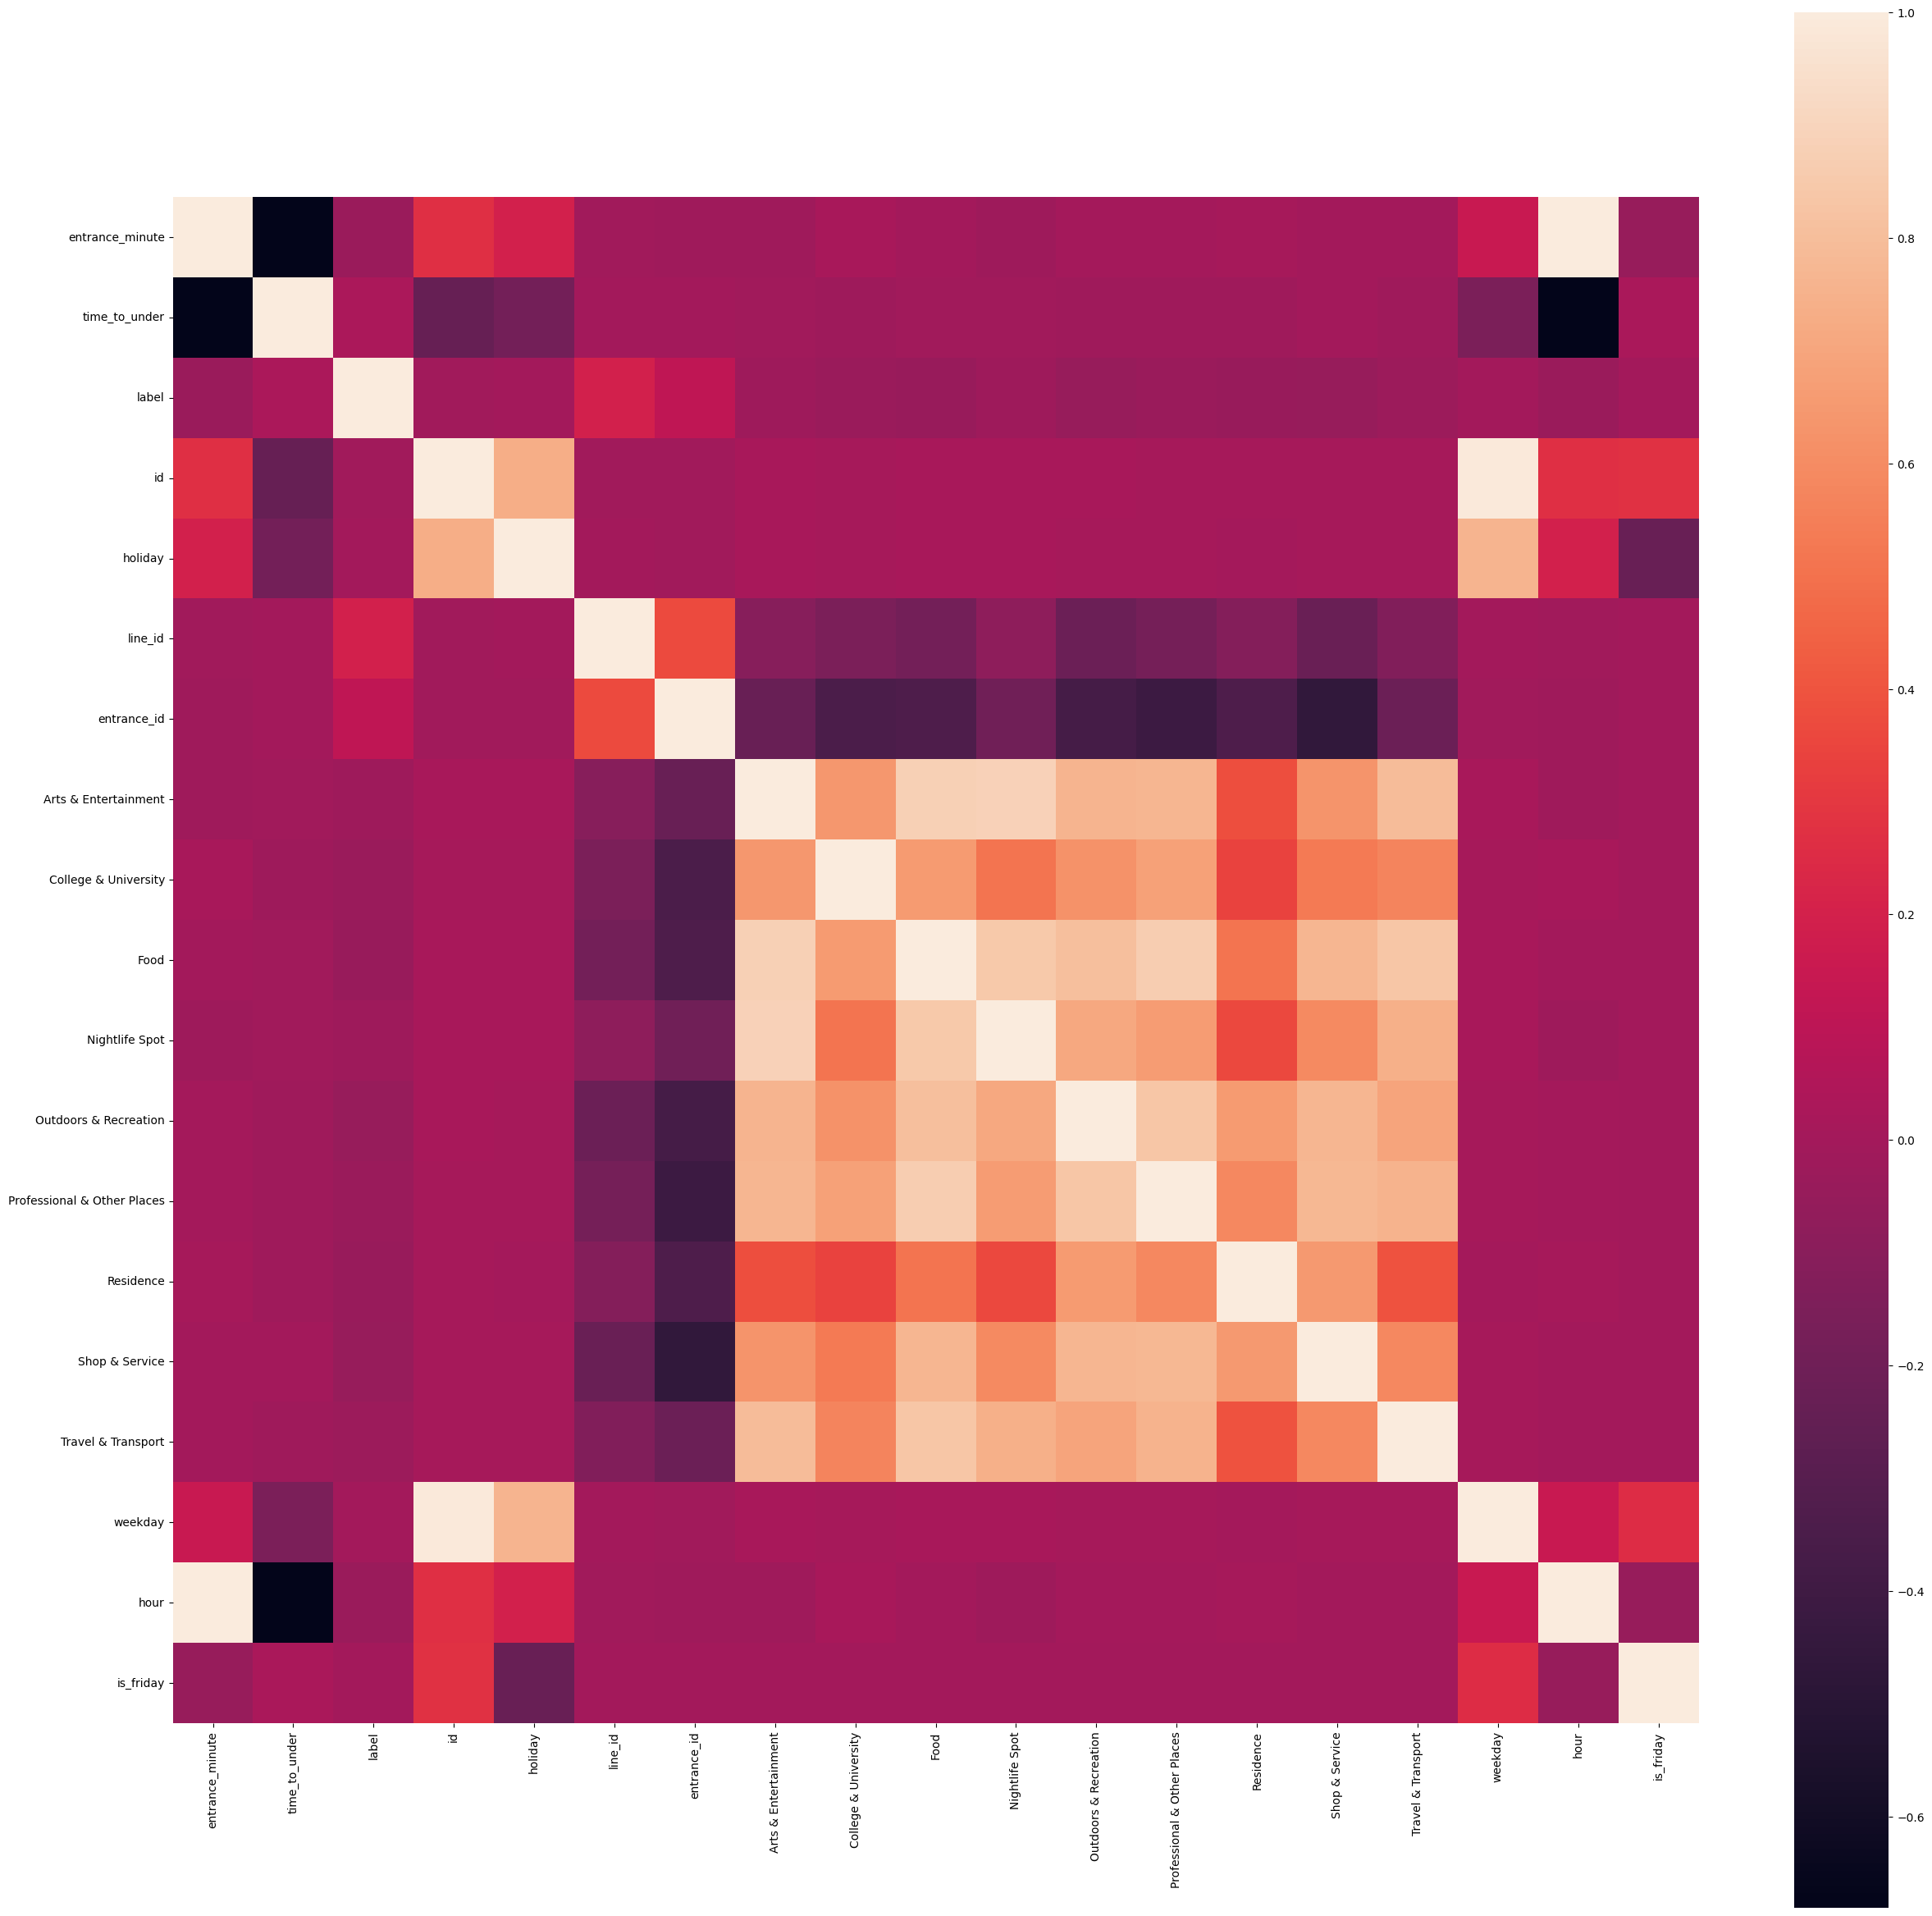

In [6]:
plt.figure(figsize = (30,30))
data2 = data[['entrance_minute', 'time_to_under', 'label', 'id', 
                 'holiday', 'line_id', 'ticket_id', 'entrance_id', "Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport", "weekday", "hour", "is_friday"]]
sns.heatmap(data2.corr(), square = True)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

dataa = data[["entrance_minute", "id", "hour", "weekday"]]

scaler = StandardScaler()
scaler.fit(dataa)
new_data = scaler.transform(dataa)

scaler2 = MinMaxScaler(feature_range = [-1,1])
scaler2.fit(new_data)
new_data = scaler2.transform(new_data)

data[["entrance_minute", "id", "hour", "weekday"]] = new_data

In [8]:
data[["entrance_minute", "id", "hour", "weekday"]].describe()

,entrance_minute,id,hour,weekday
count,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06
mean,-1.658136e-01,-1.094124e-16,-1.915326e-01,-6.708792e-02
std,2.882896e-01,5.773511e-01,2.948820e-01,6.469820e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.503909e-01,-5.000000e-01,-3.913043e-01,-6.666667e-01
50%,-2.551528e-01,-1.110223e-16,-3.043478e-01,4.163336e-17
75%,-5.188344e-02,5.000000e-01,-4.347826e-02,3.333333e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


good_words = ["Студента", "студента", "учащегося", "Учащегося"]
good_names = []

for i in data["ticket_type_nm"].unique():
    if any(word in i for word in good_words):
        if i not in good_names:
            good_names.append(i)
        
good_words = ["Студента", "студента", "учащегосося", "Учащегося"]
student_data = pd.DataFrame()

for i in range(len(good_names)-1):
    good_rows = data[data["ticket_type_nm"] == good_names[i]]
    student_data = student_data.append(good_rows)

        



In [9]:
other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [other_items, categorical_features]

big1d_list = [item for sublist in big2d_list for item in sublist]
big1d_list.remove('label')
big1d_list.remove('time_to_under')
data_X = data[big1d_list]
data_y = data["time_to_under"]


X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
                                                    test_size = 0.2, random_state = 11)


reg = LinearRegression().fit(X_train, y_train)

reg2 = BayesianRidge().fit(X_train, y_train)

#reg3 = KernelRidge(alpha=1.0).fit(X_train, y_train)

y_pred = reg.predict(X_test)
y2_pred = reg2.predict(X_test)
#y3_pred = reg3.predict(X_test)



print("mape1: " + str(mape(y_pred, y_test)))
print("mse1: " + str(mse(y_pred, y_test)))

print("mape2: " + str(mape(y2_pred, y_test)))
print("mse2: " + str(mse(y2_pred, y_test)))

r2_sc = r2_score(y_test, y_pred)
print("r2_sc = ", r2_sc)

#print("mape3: " + str(mape(y3_pred, y_test)))
#print("mse3: " + str(mse(y3_pred, y_test)))

mape1: 0.46486212067557564
mse1: 5.451998253759968e+20
mape2: 0.48503176550716415
mse2: 27043.87360687173
r2_sc =  -1.0014585439084736e+16


#ОБРАБОТКА ВЫБРОСОВ

In [10]:
def calculate_outliners(data):
    
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries

feature_groups = ["station_id", "line_id", "entrance_id", "ticket_type_nm"] + new_features + ["entrance_minute"]

INDEXES = []


for f_group in feature_groups:
    print(f_group)
    for feature in list(data[f_group].unique()):
        tu = data[data[f_group] == feature]
        ttt = tu["time_to_under"]
        bound = calculate_outliners(ttt)
        indexes = tu[(ttt<bound[0]) | (ttt>bound[1])].index
        
        INDEXES += list(indexes)
        
        
data.drop(index = pd.Index(data = INDEXES), inplace = True)


station_id
line_id
entrance_id
ticket_type_nm
Arts & Entertainment
College & University
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport
entrance_minute


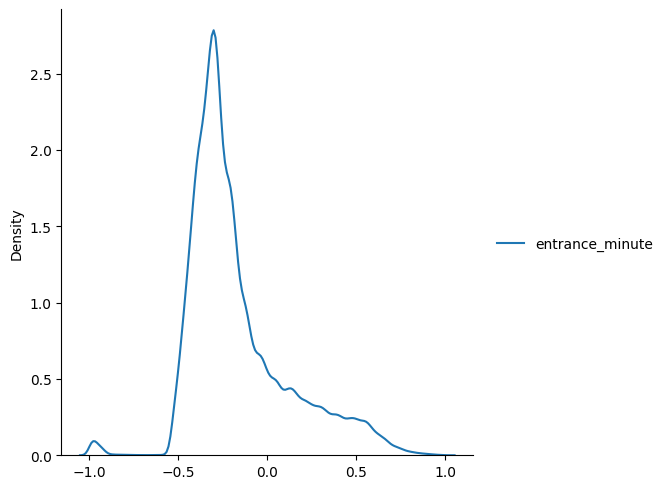

In [11]:
sns.displot(data[["entrance_minute"]], kind = "kde")

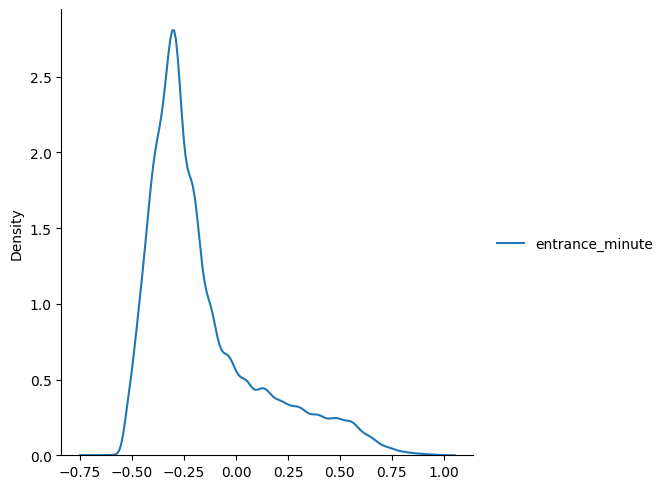

In [12]:
data = data[data["entrance_minute"] > -0.7]
sns.displot(data[["entrance_minute"]], kind = "kde")

/var/folders/85/cmh938_d61v2xzmbq56cyzdm0000gn/T/ipykernel_78236/1802083103.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 15))


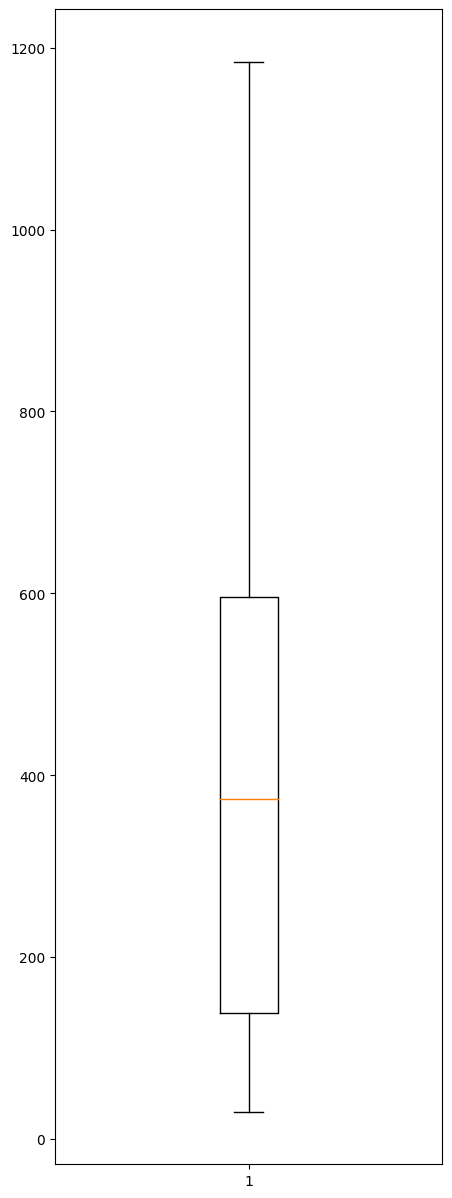

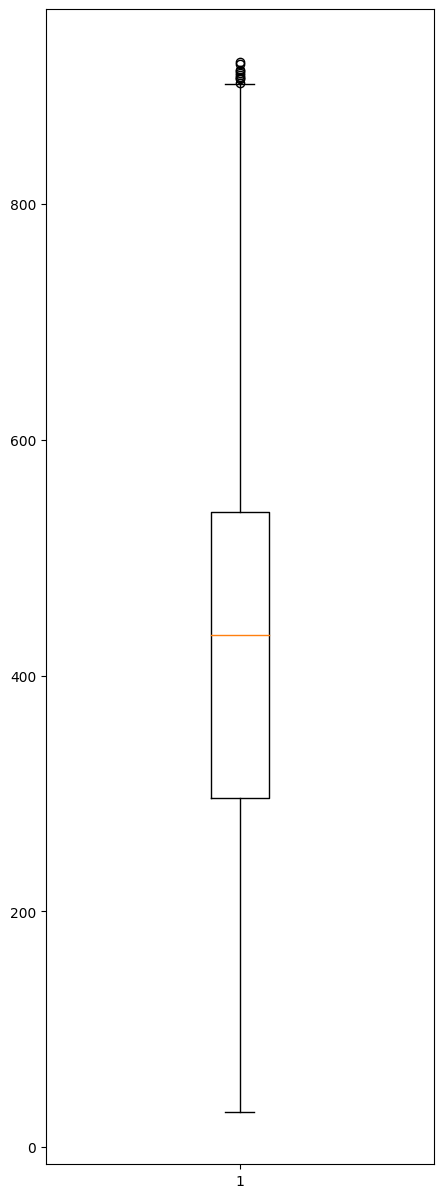

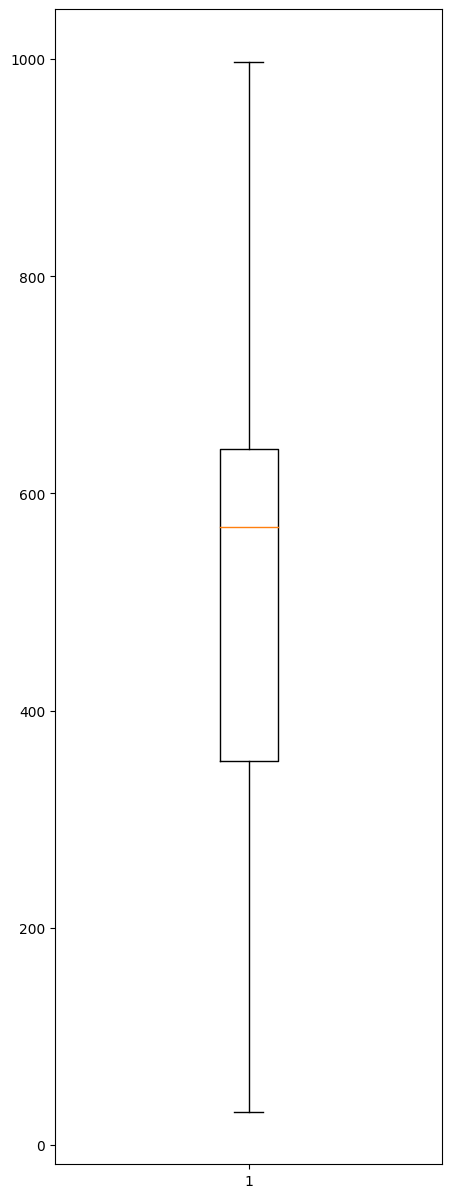

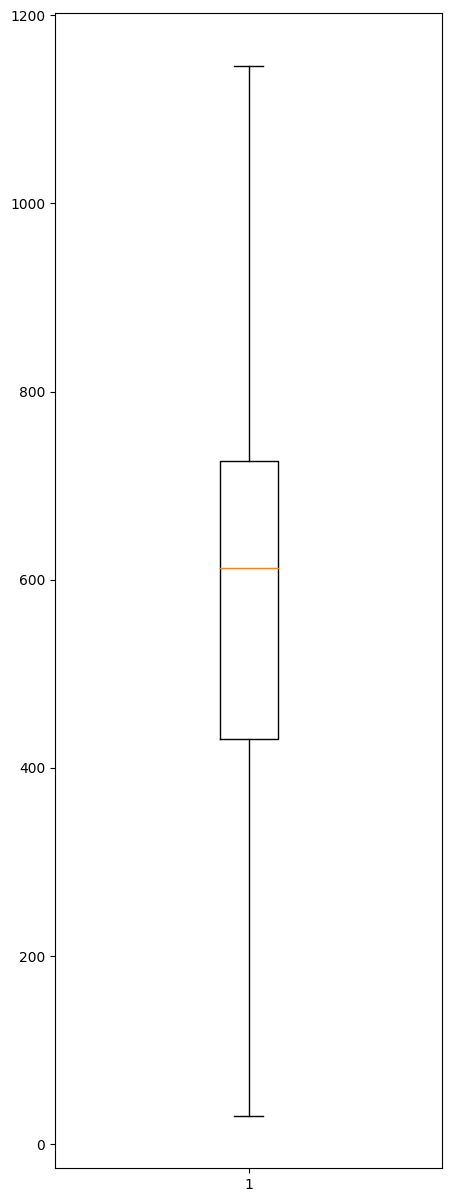

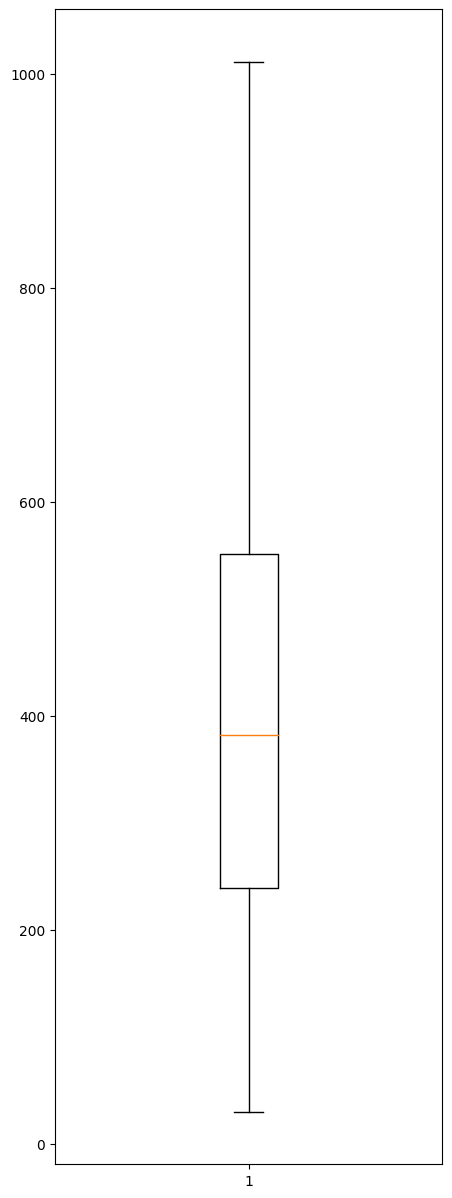

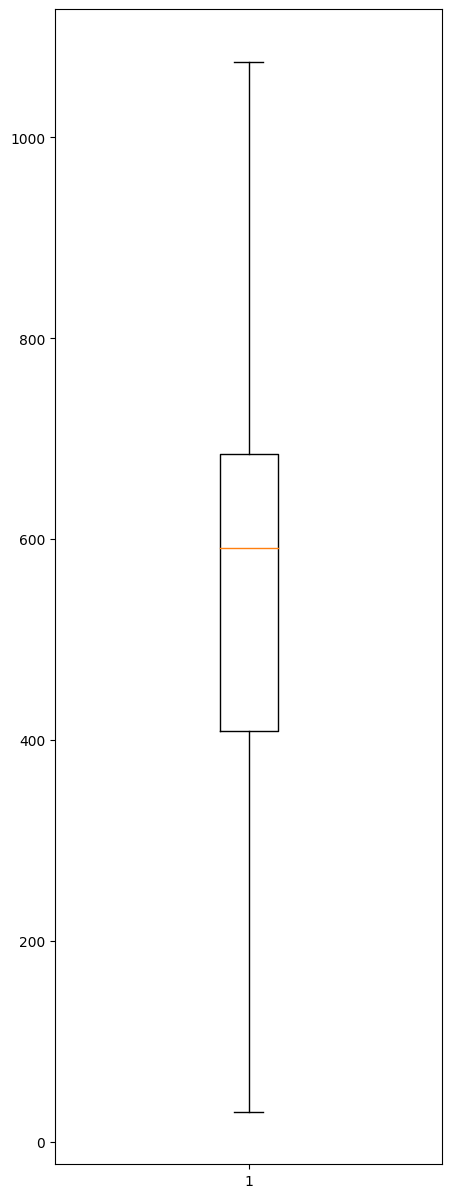

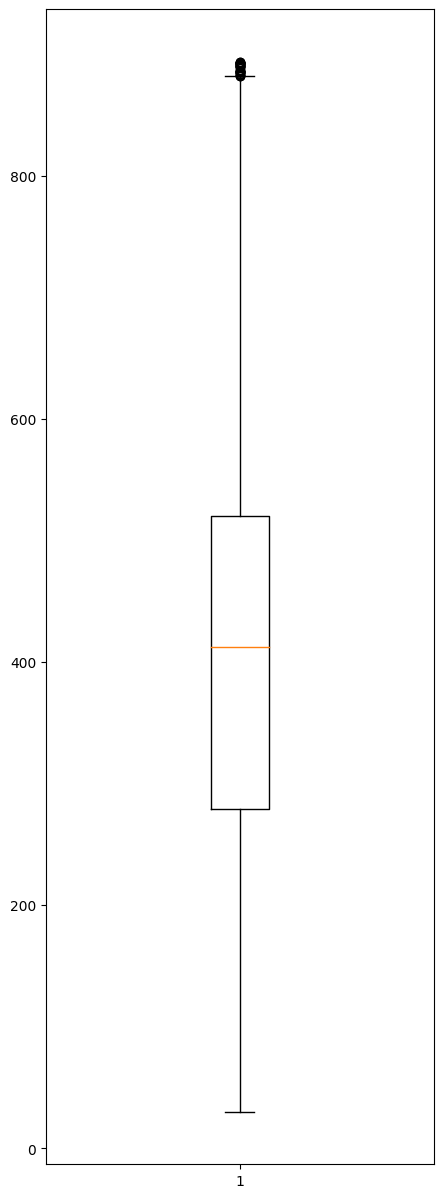

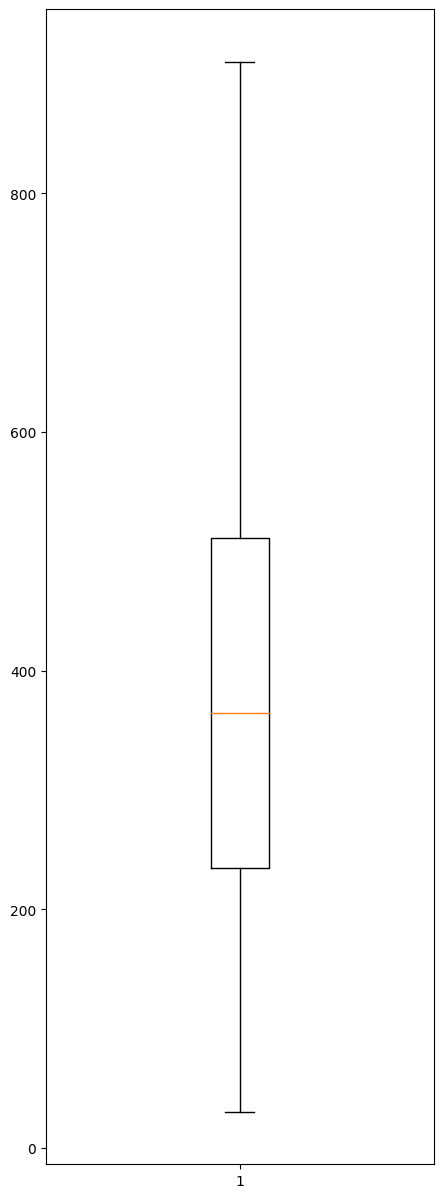

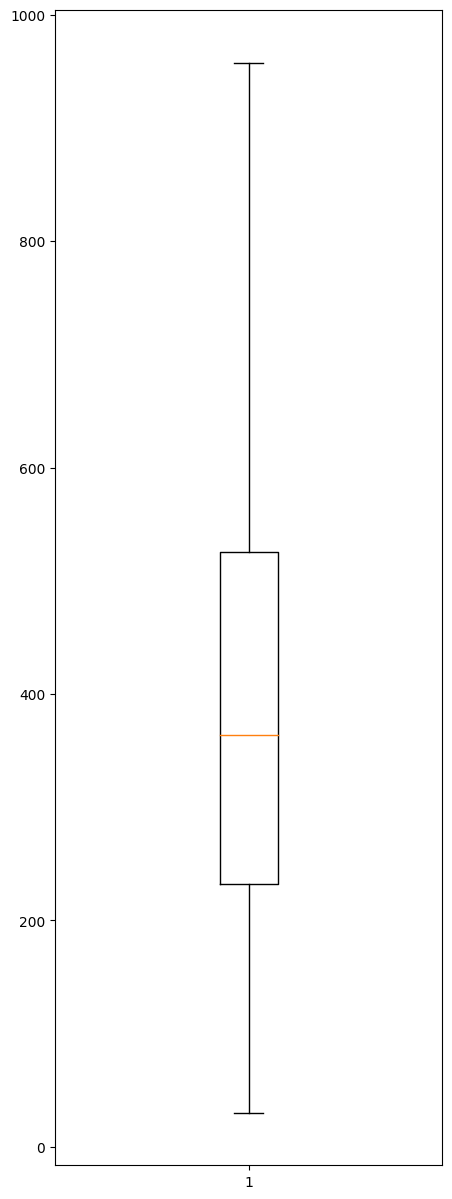

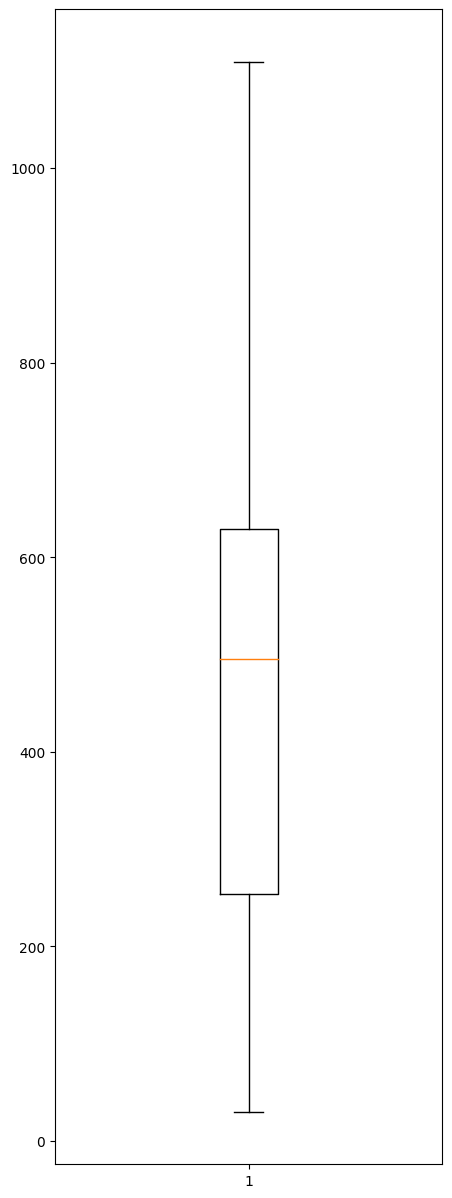

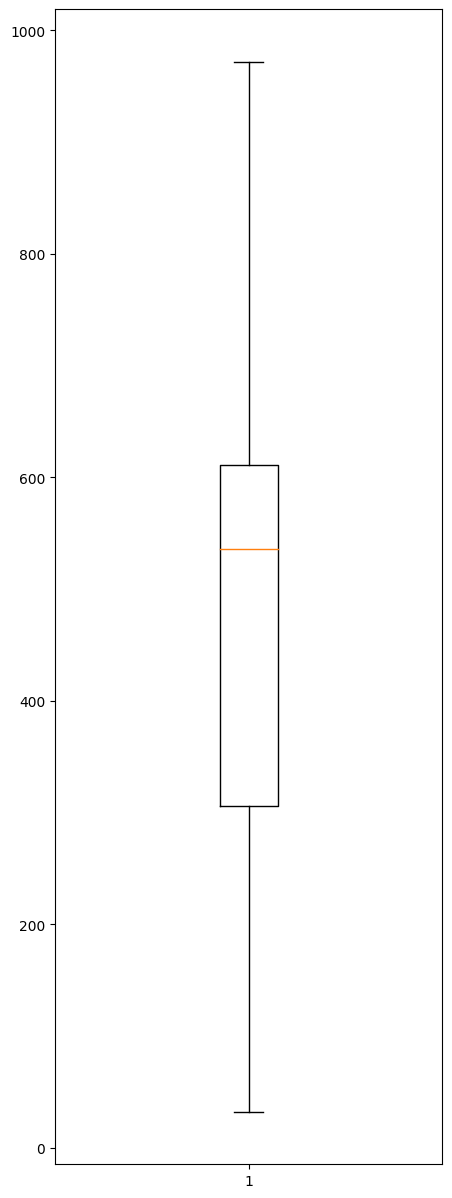

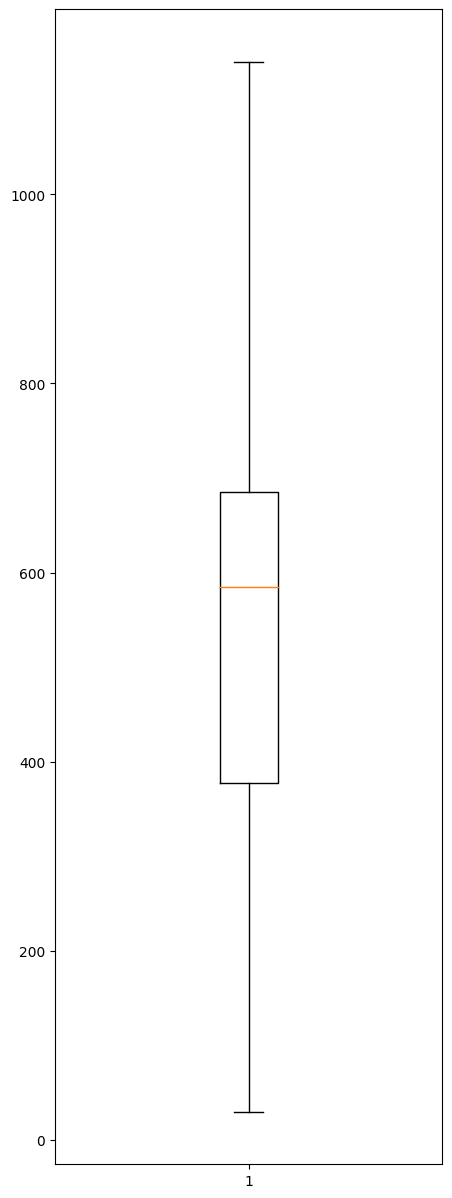

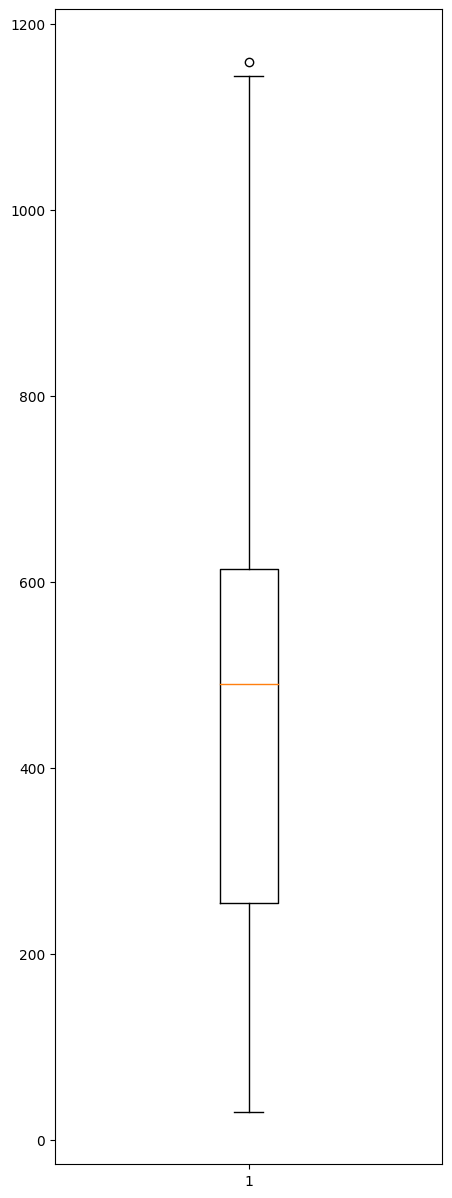

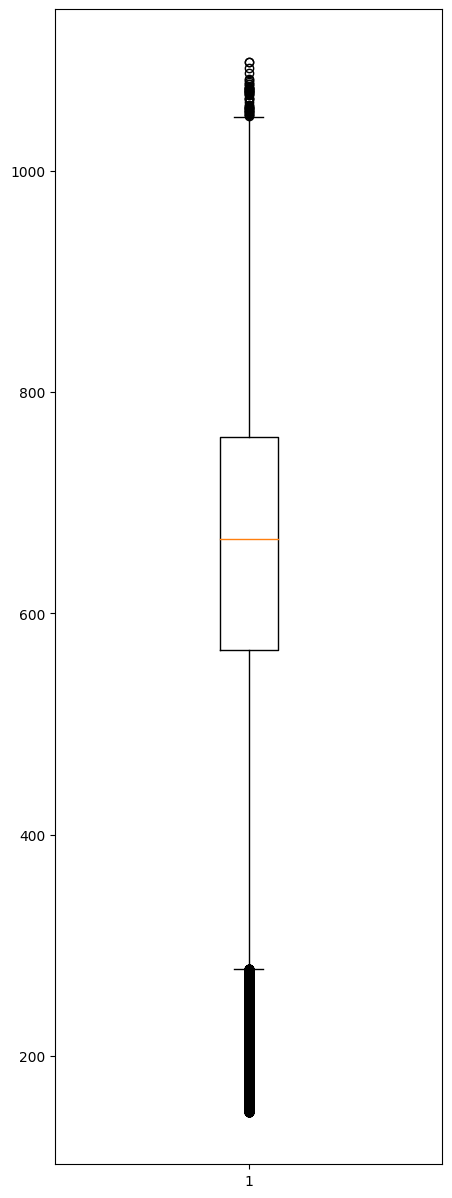

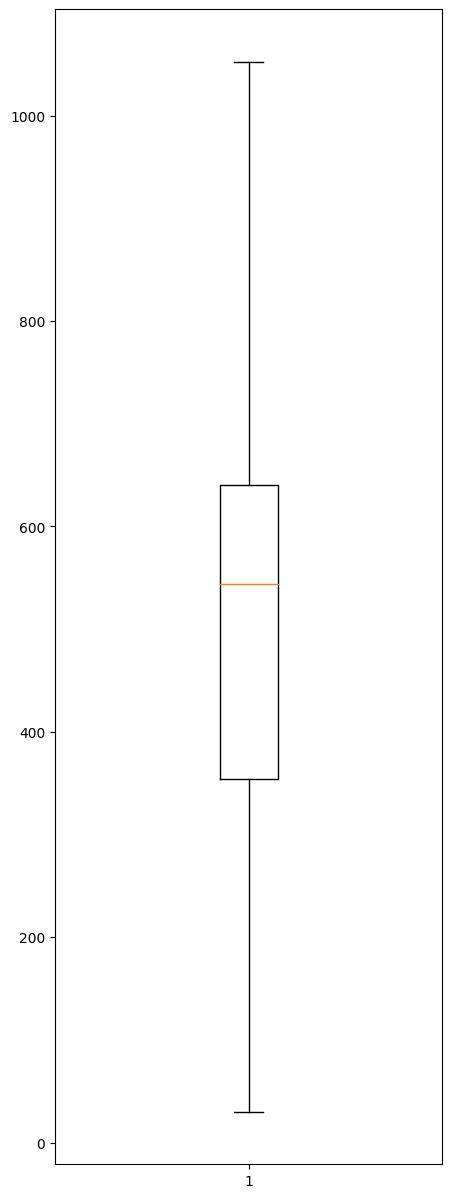

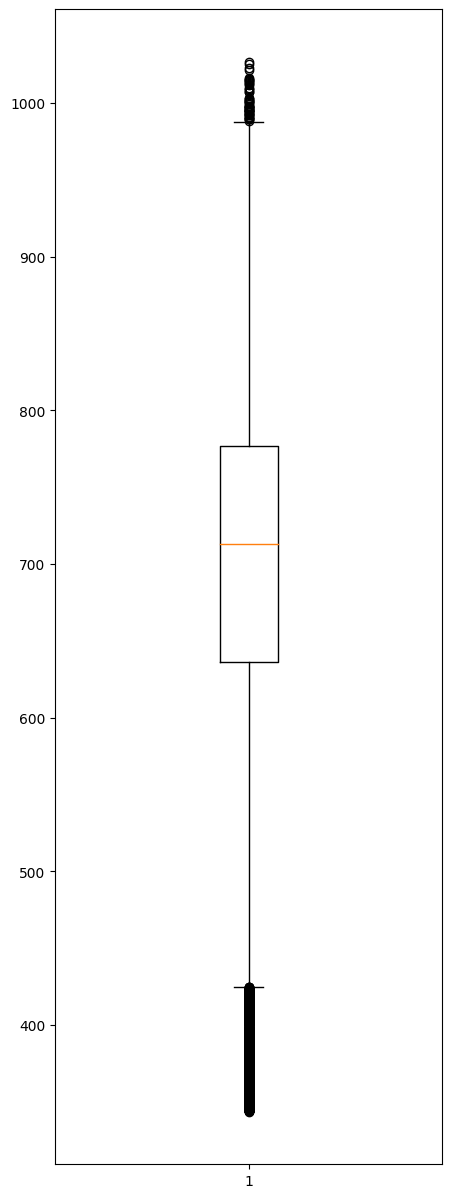

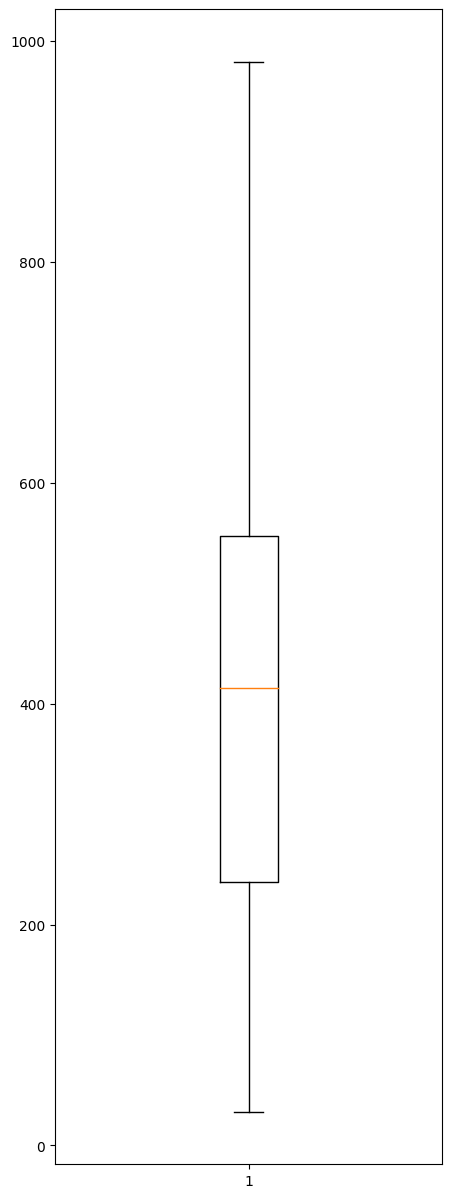

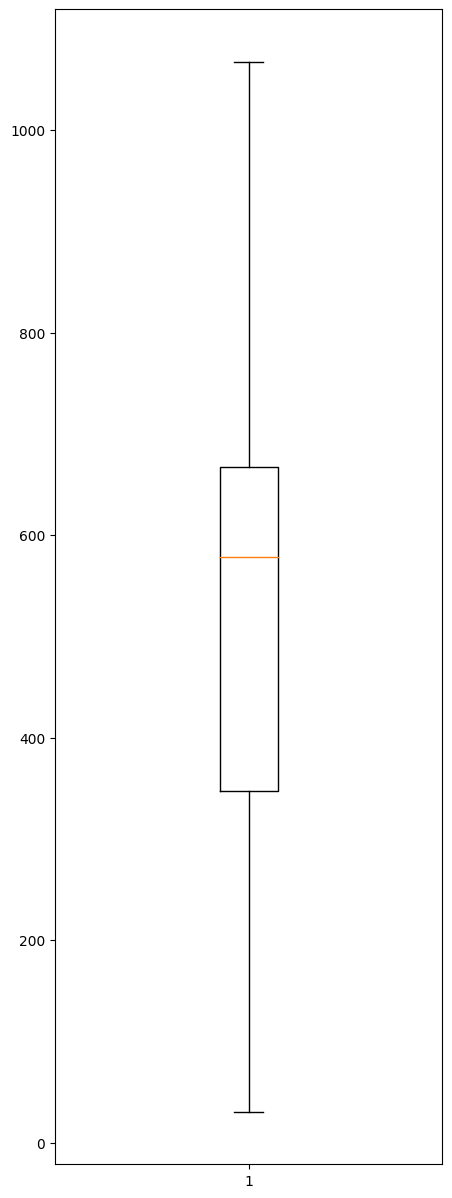

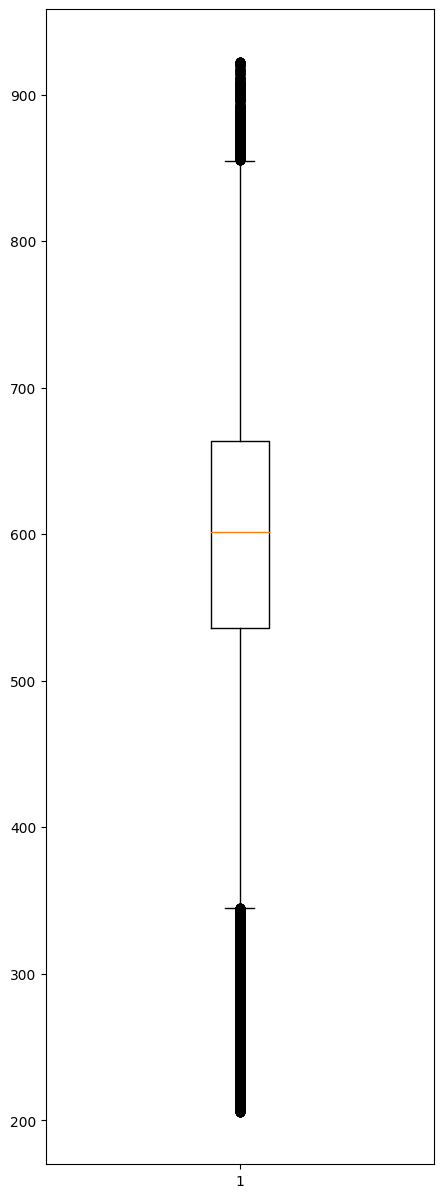

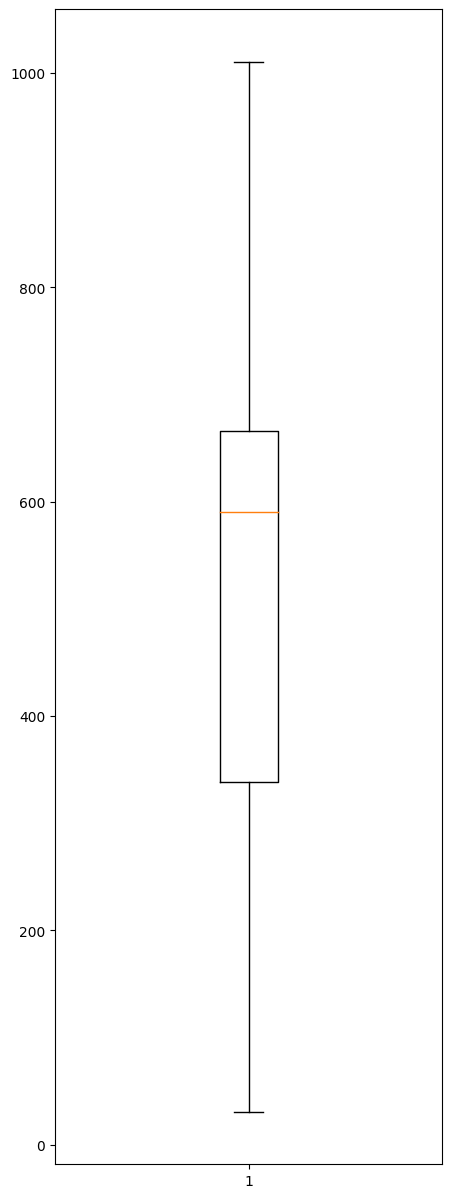

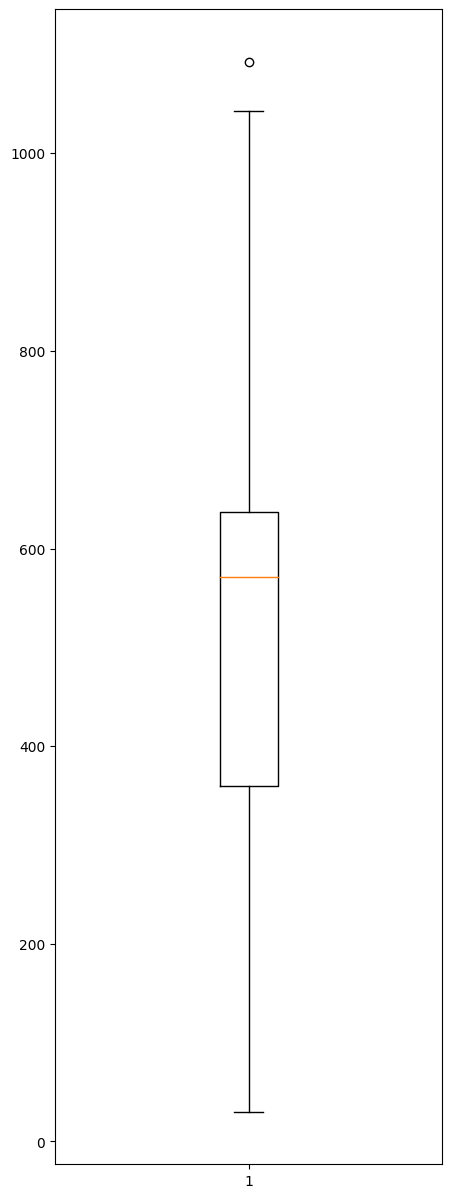

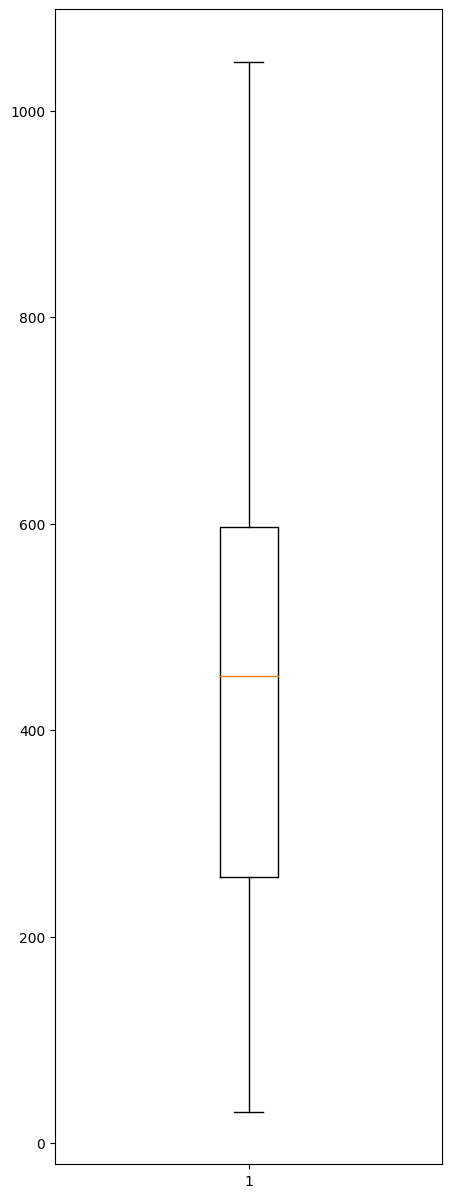

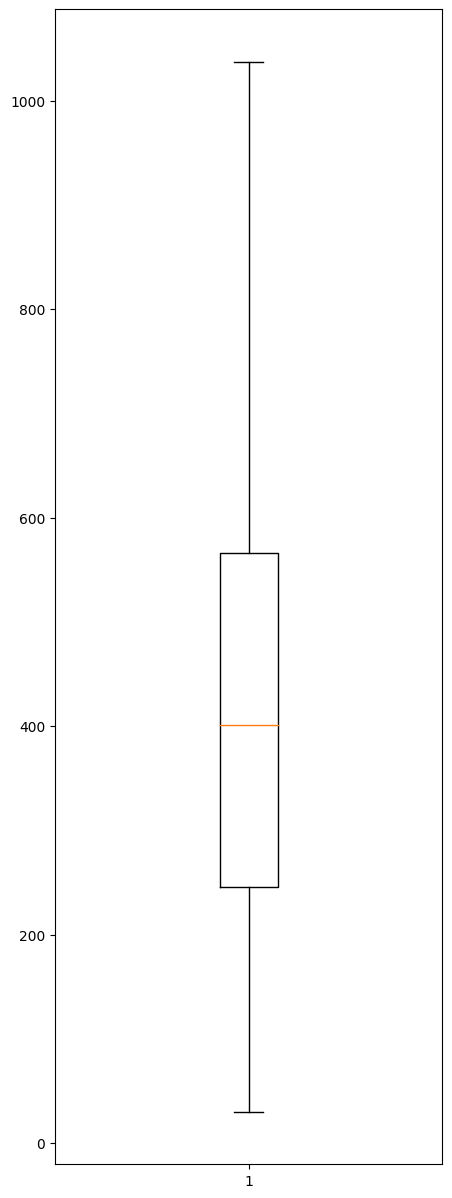

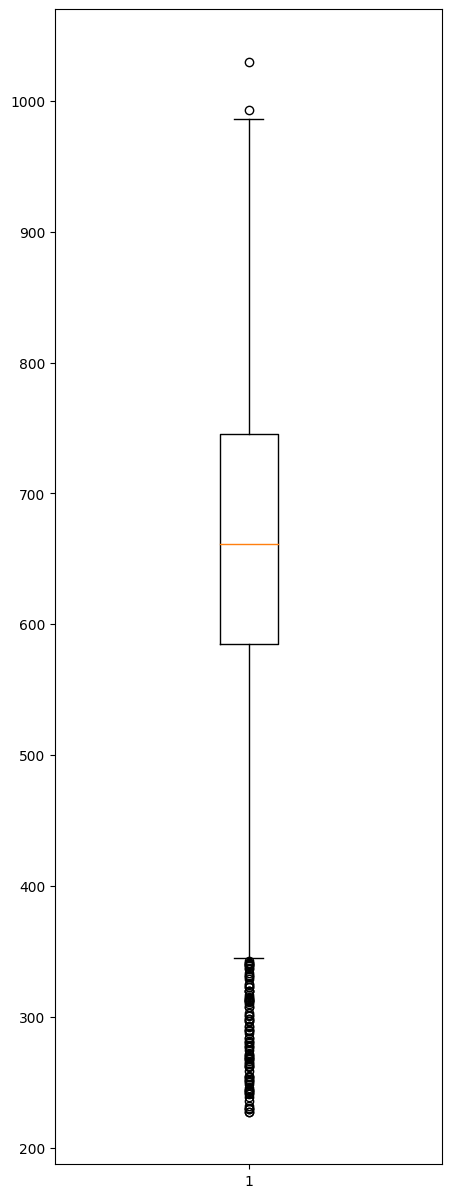

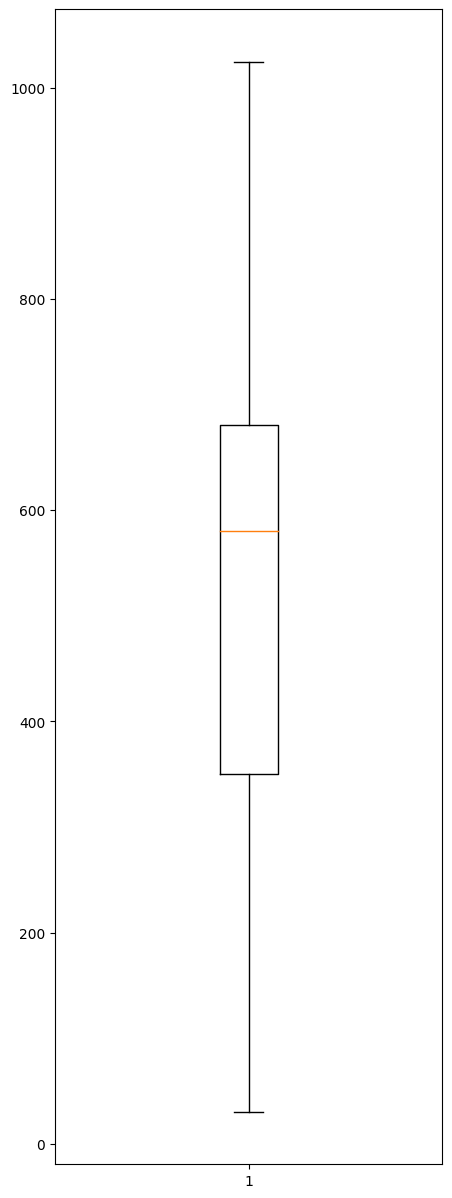

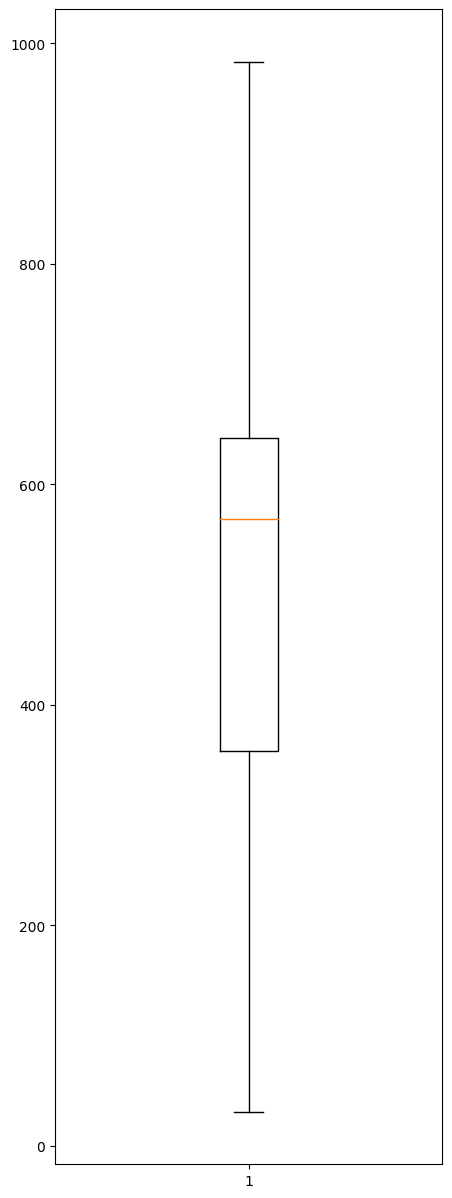

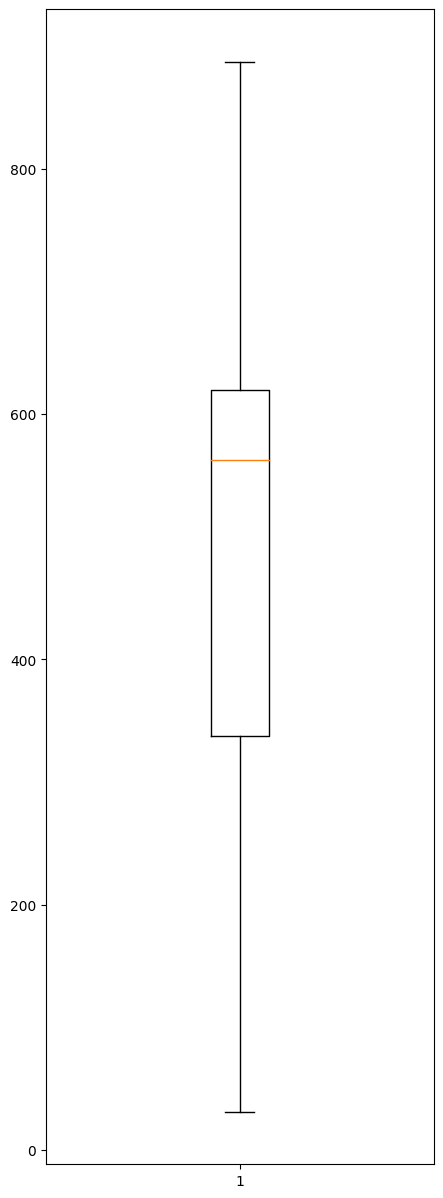

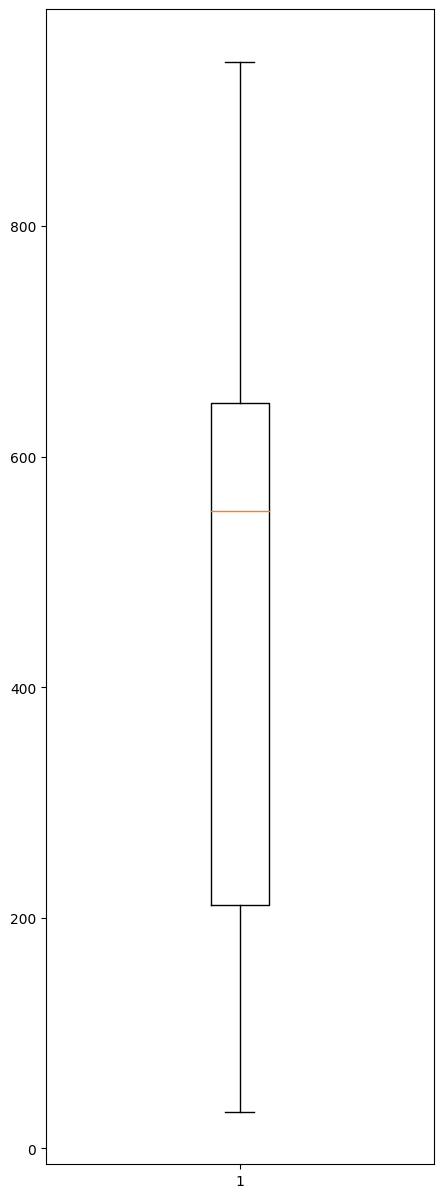

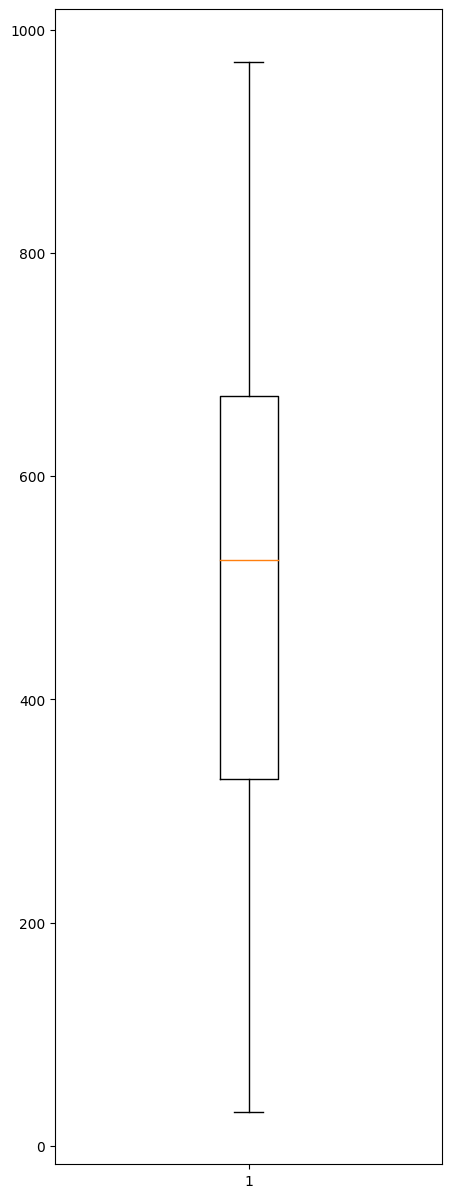

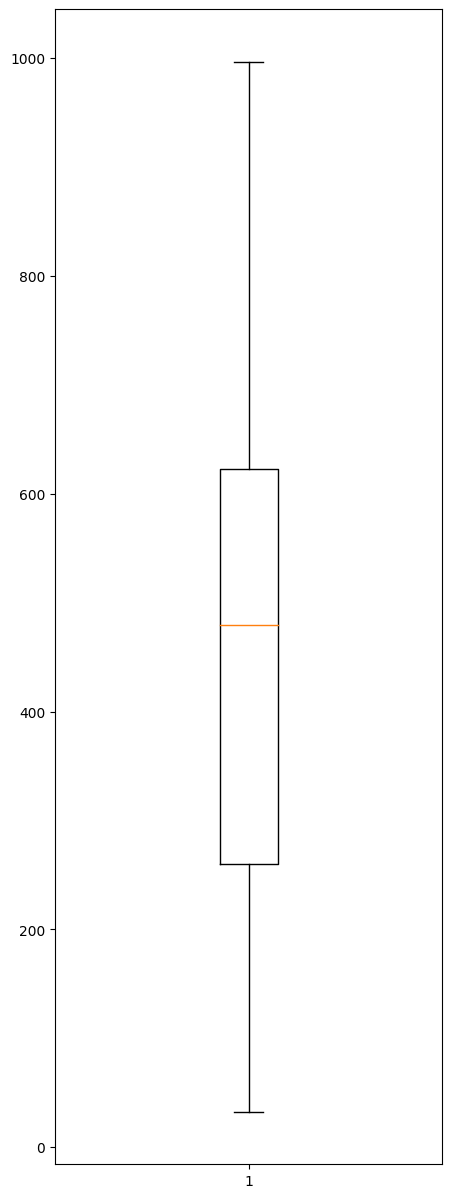

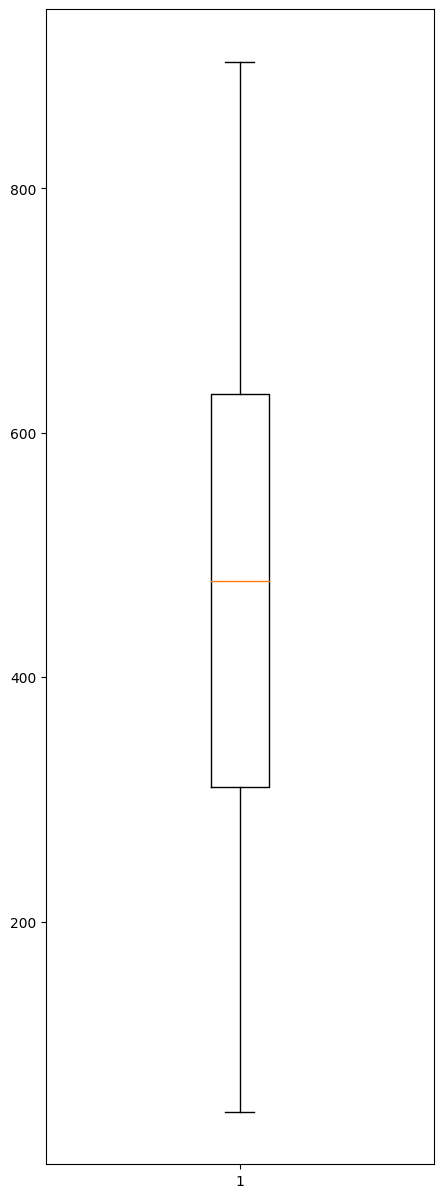

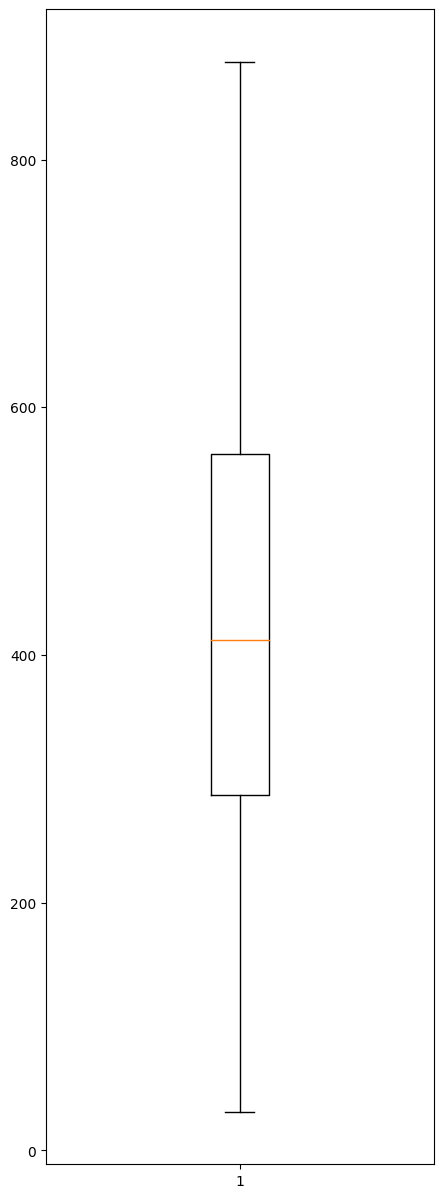

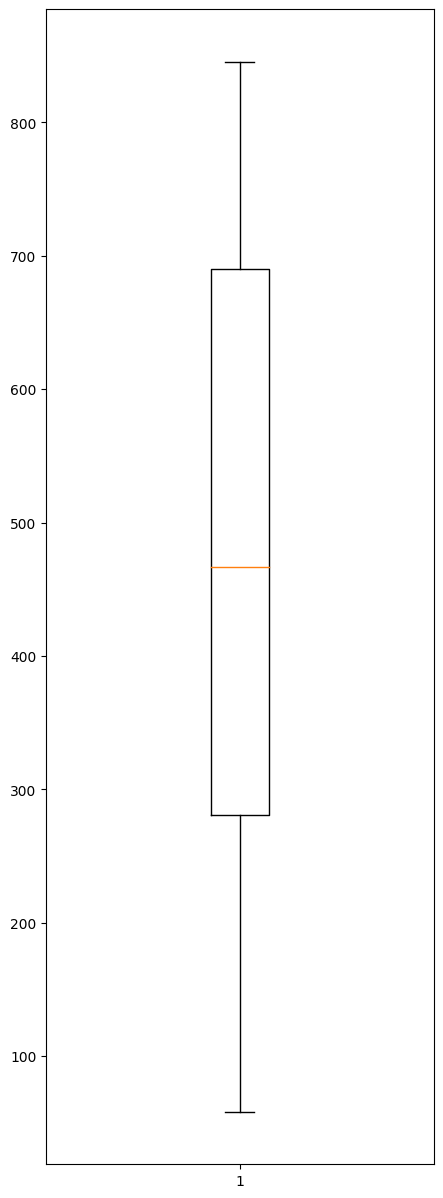

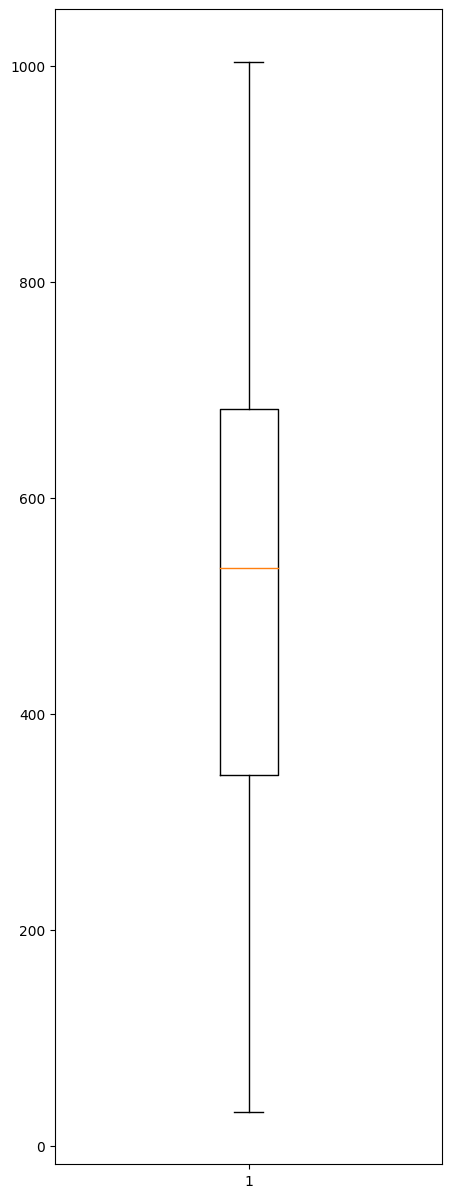

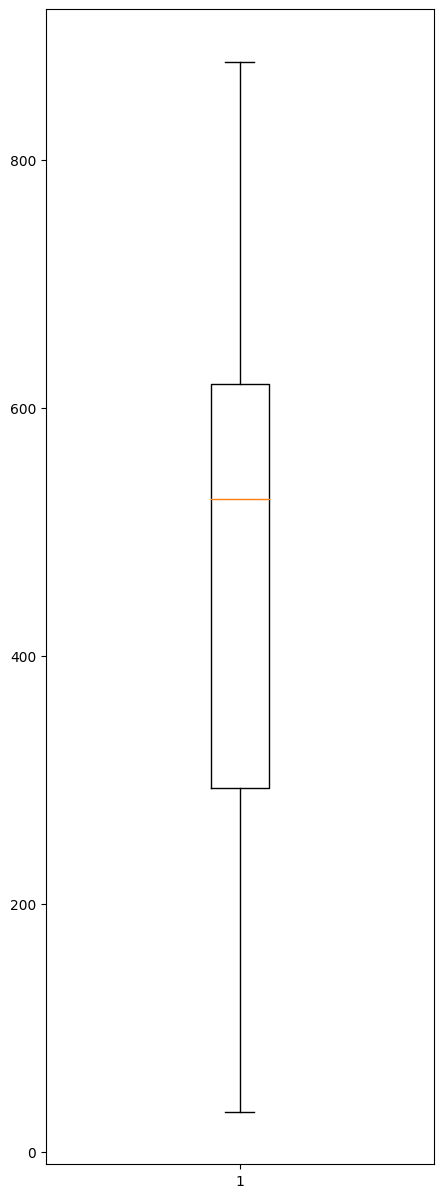

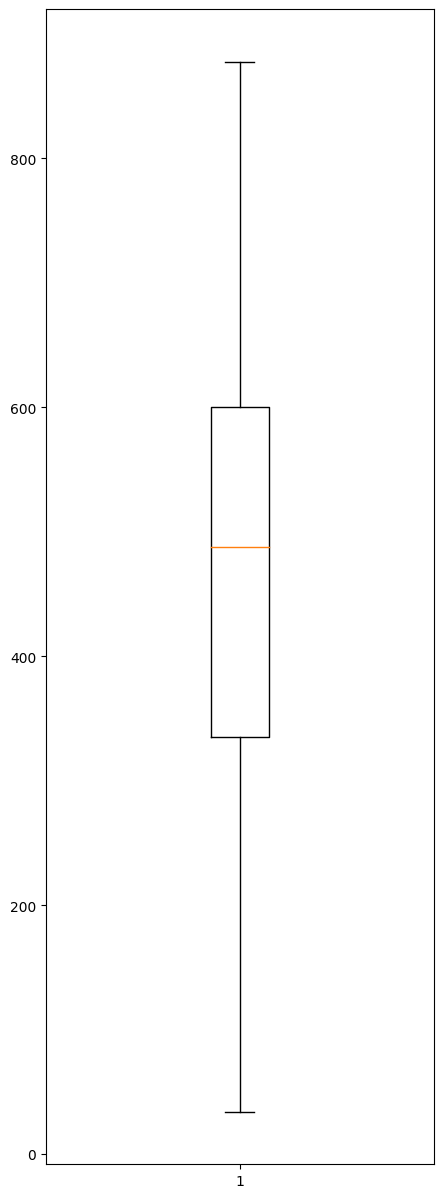

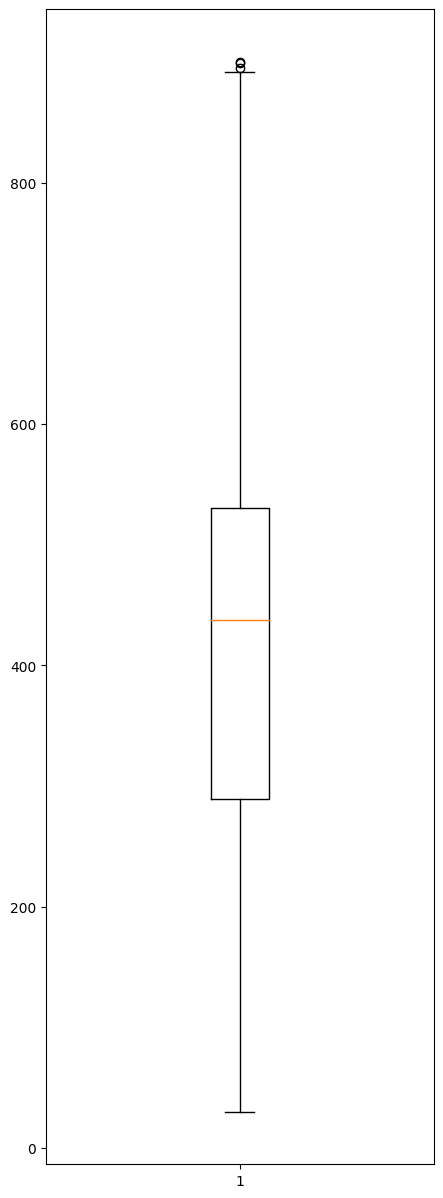

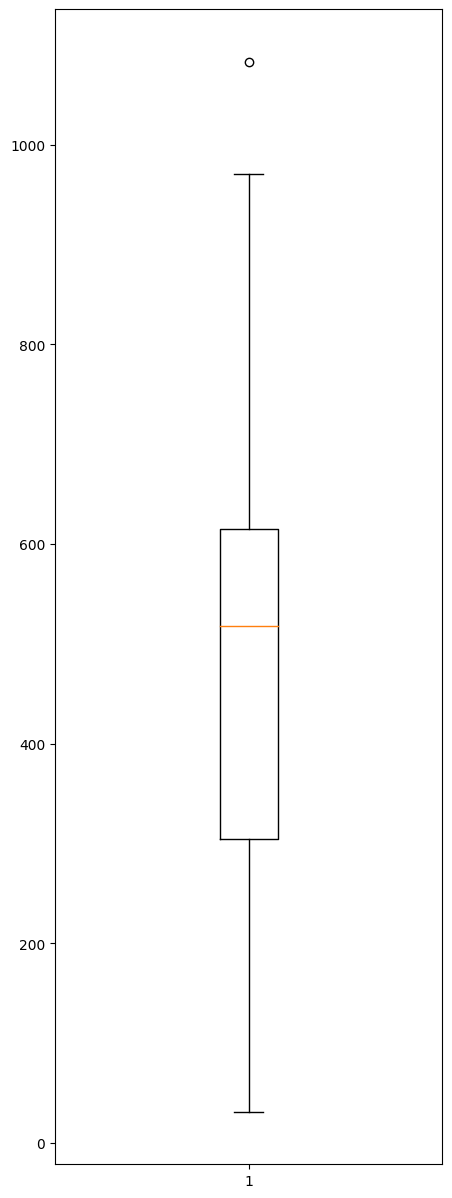

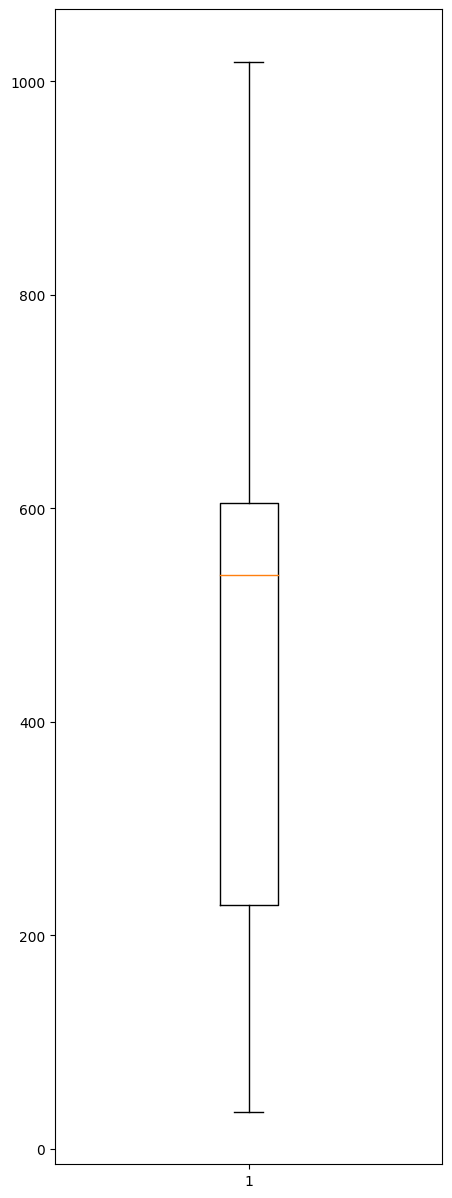

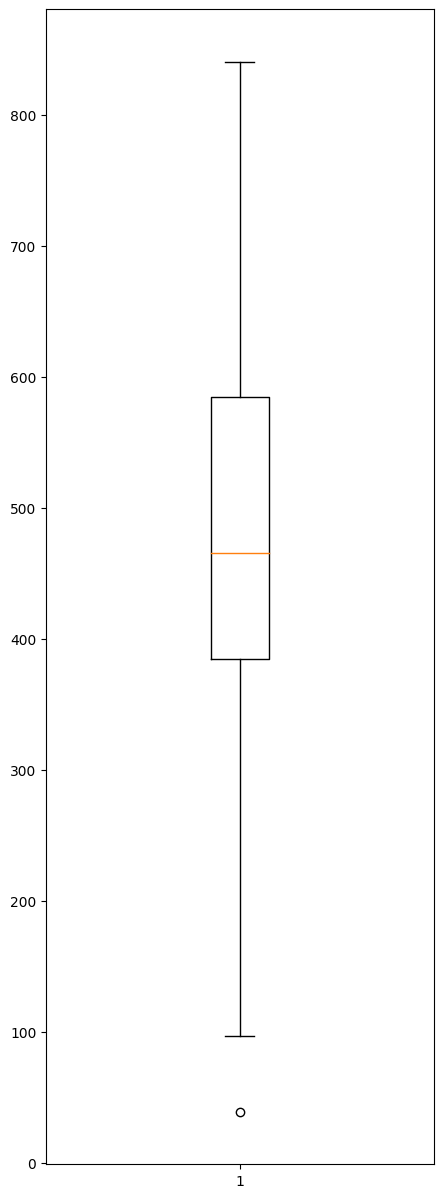

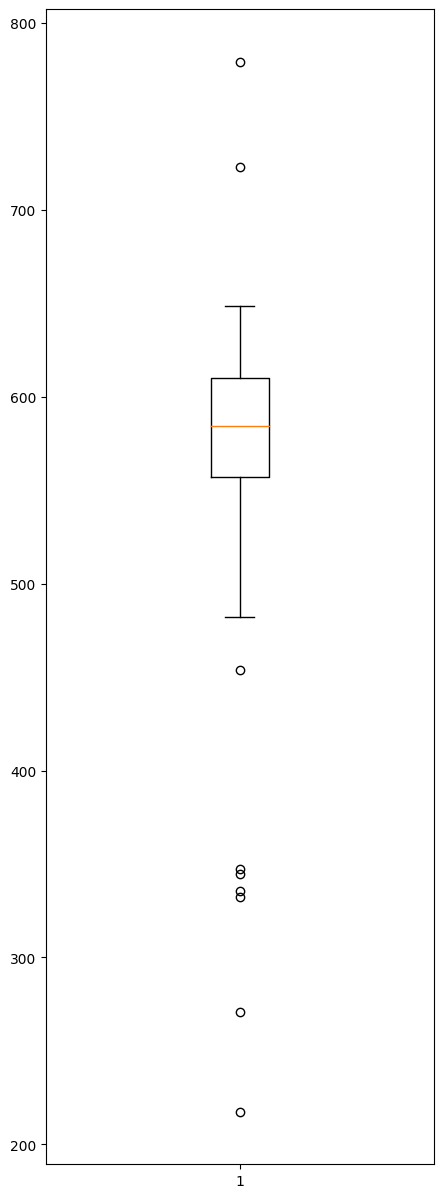

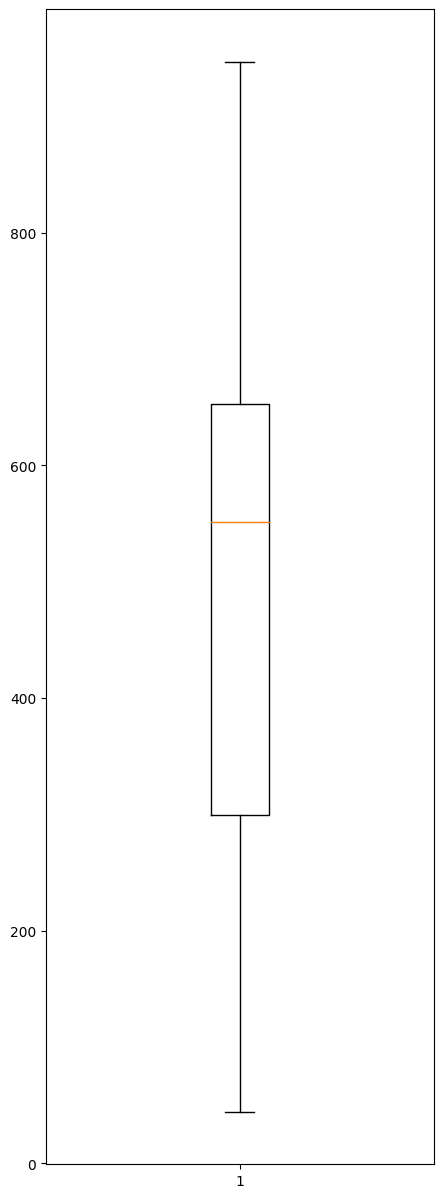

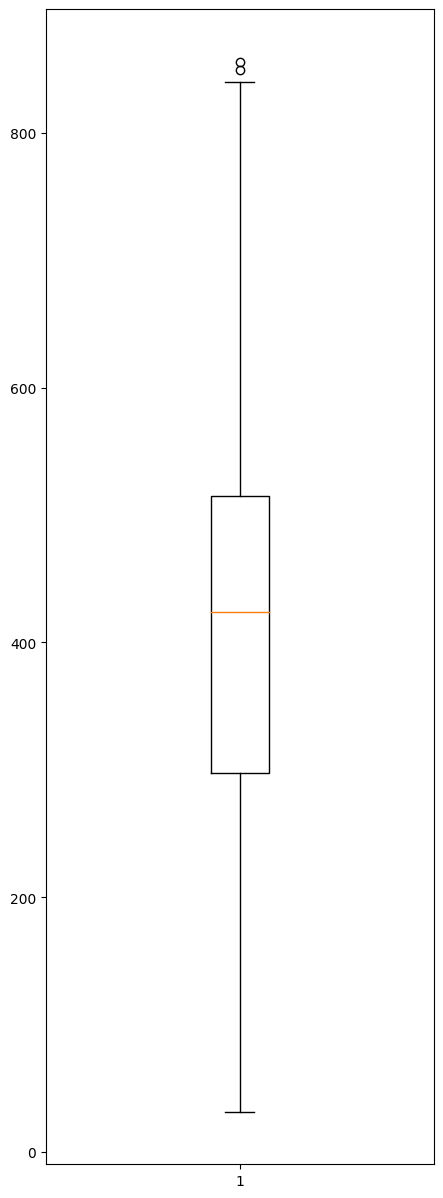

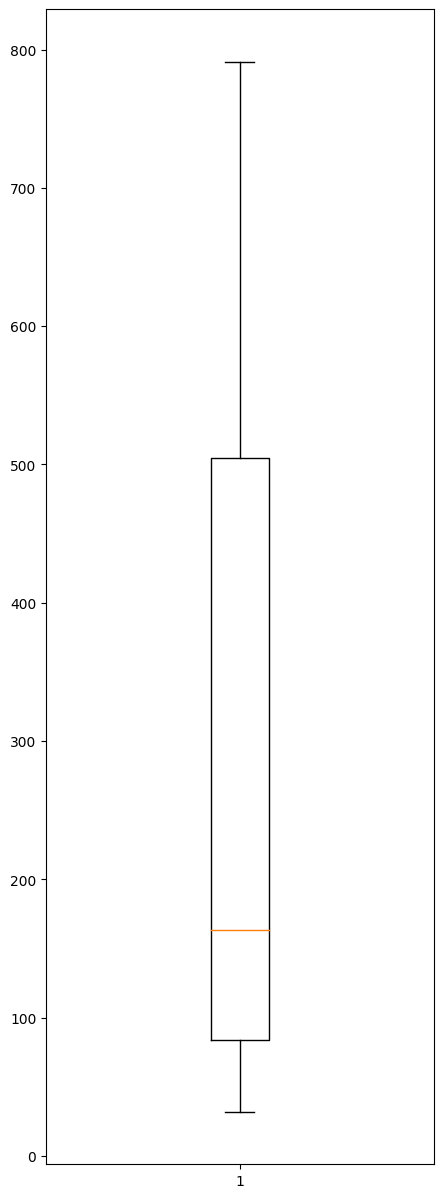

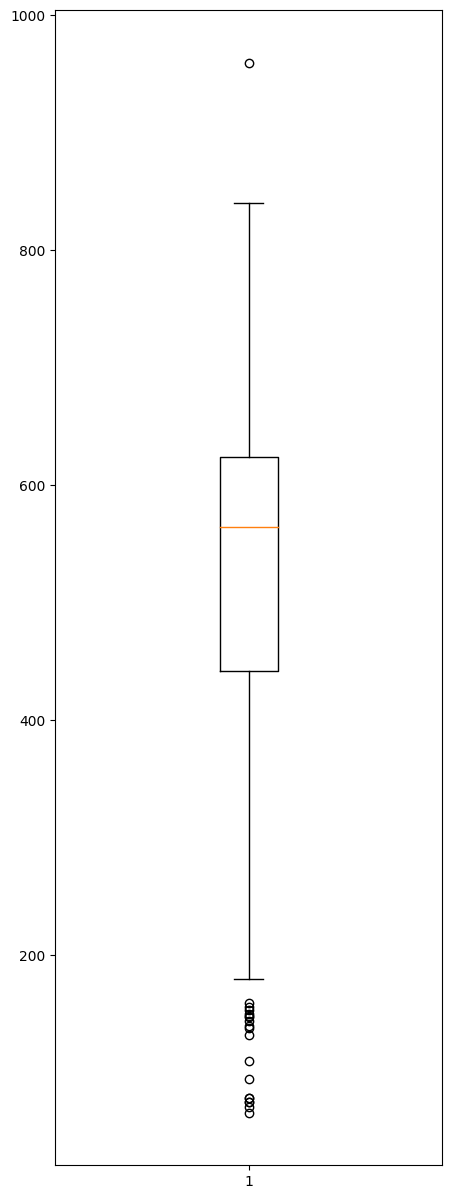

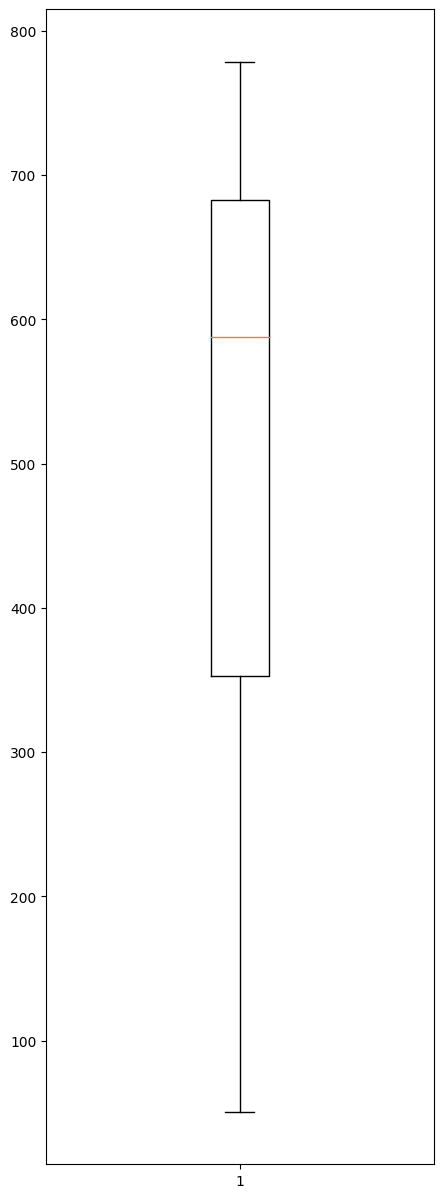

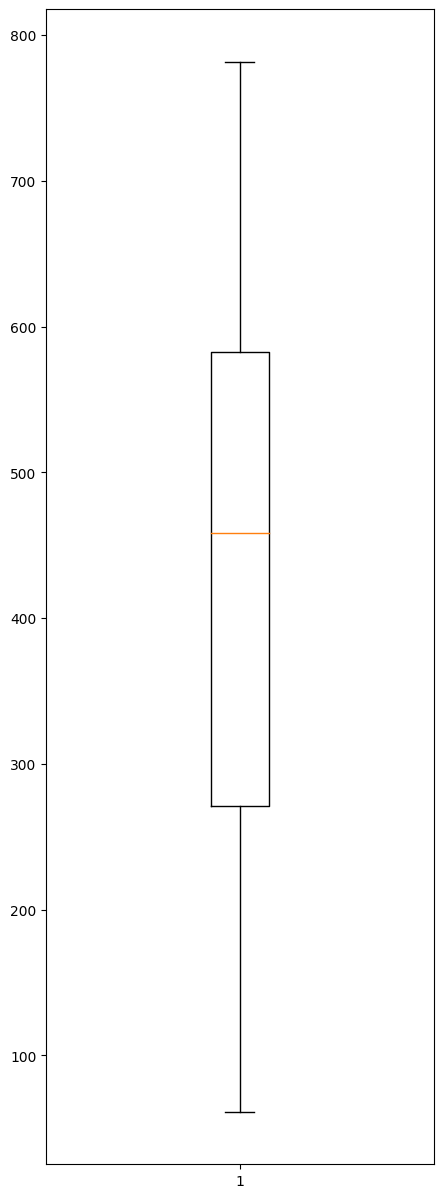

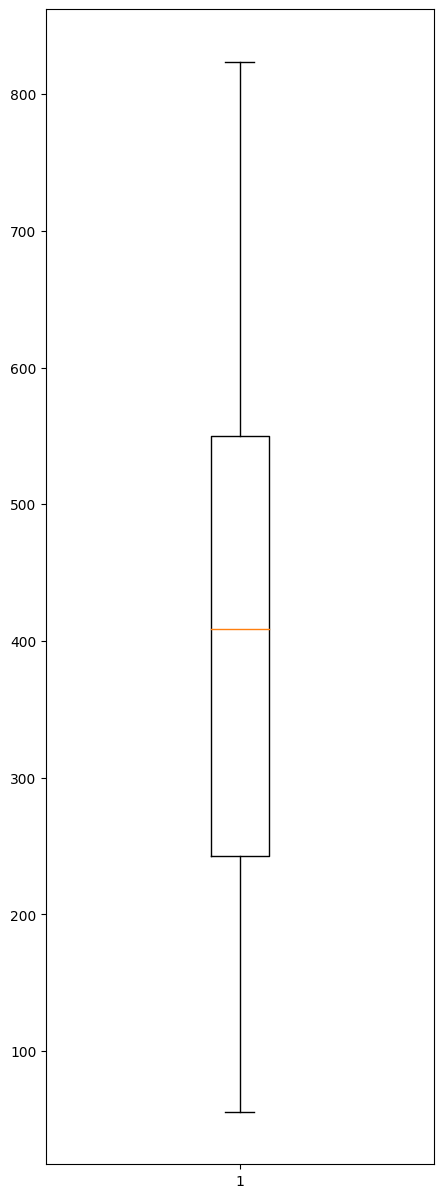

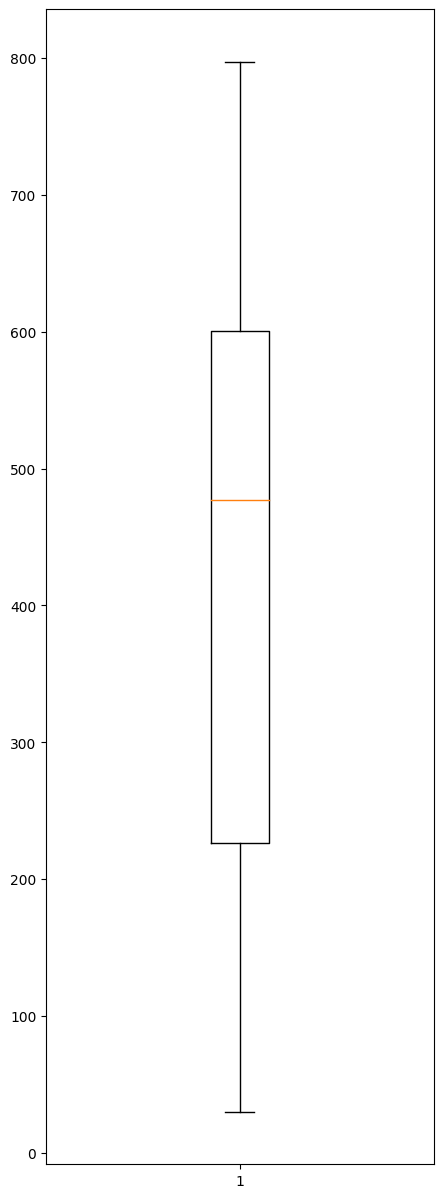

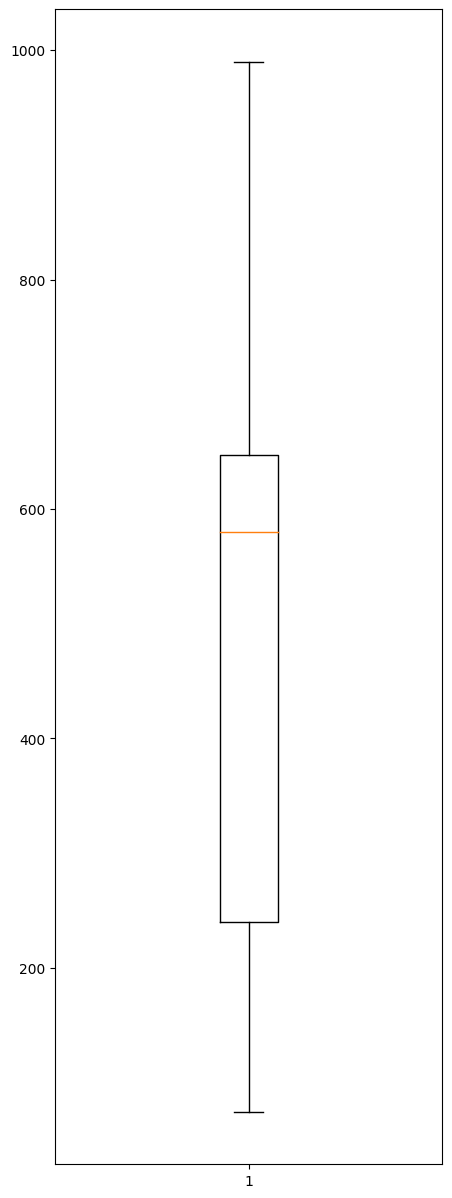

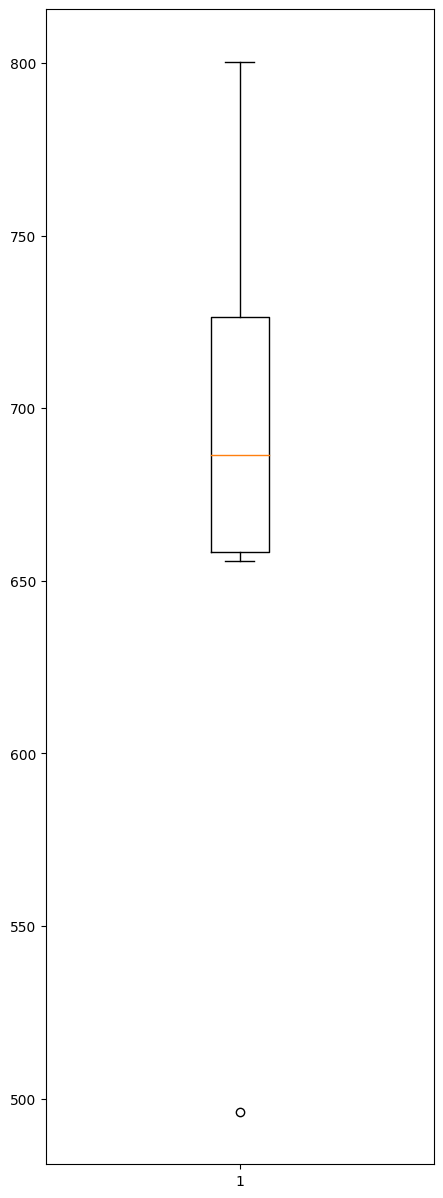

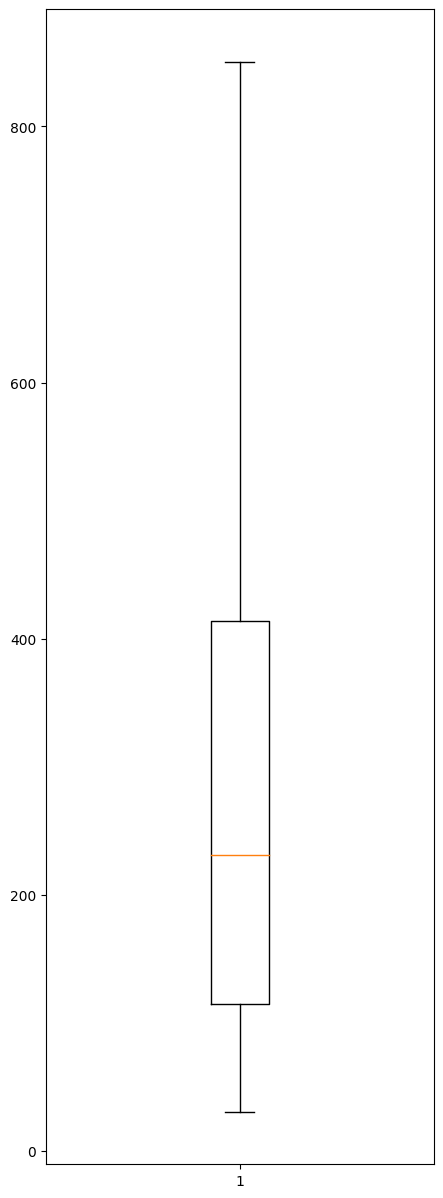

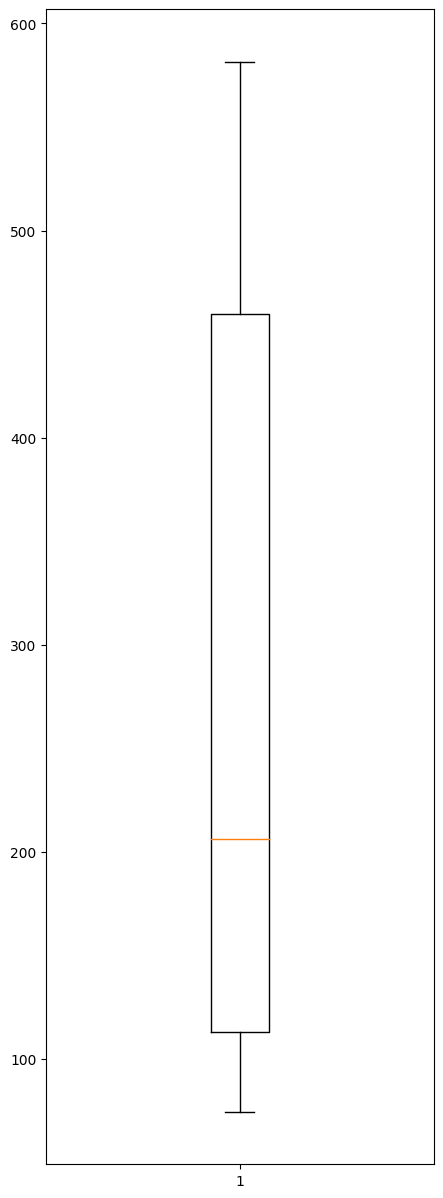

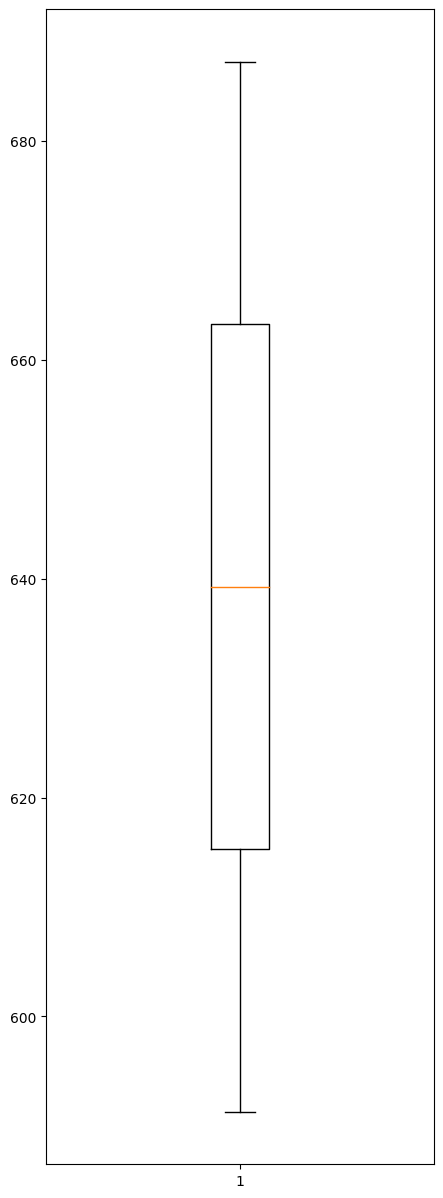

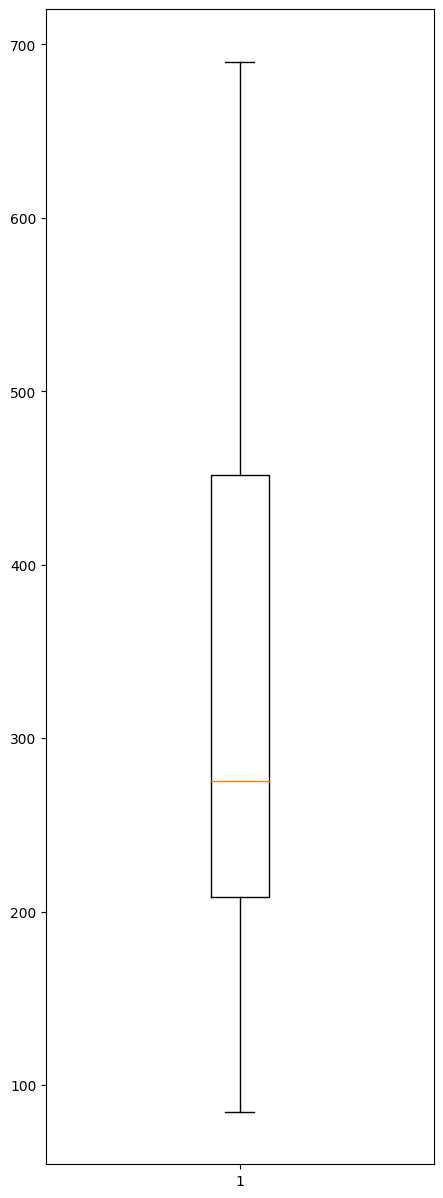

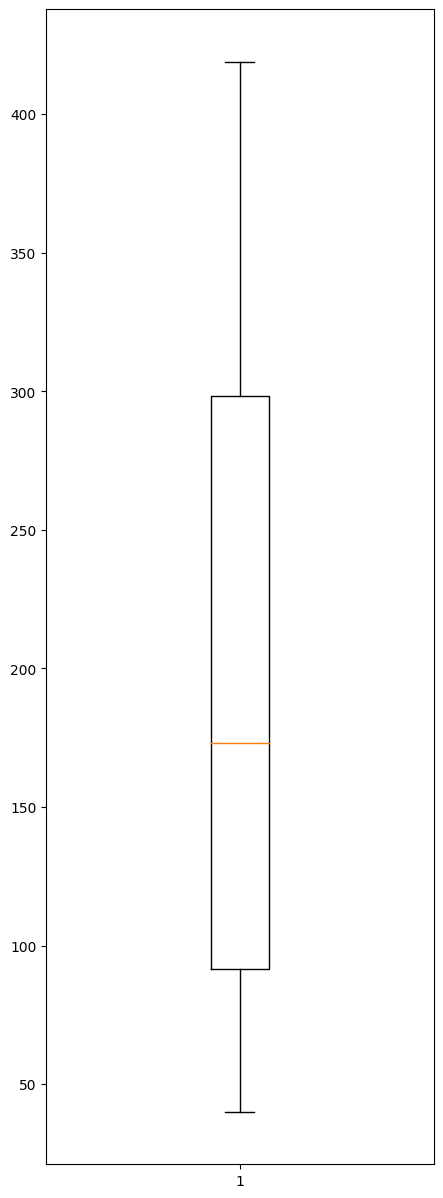

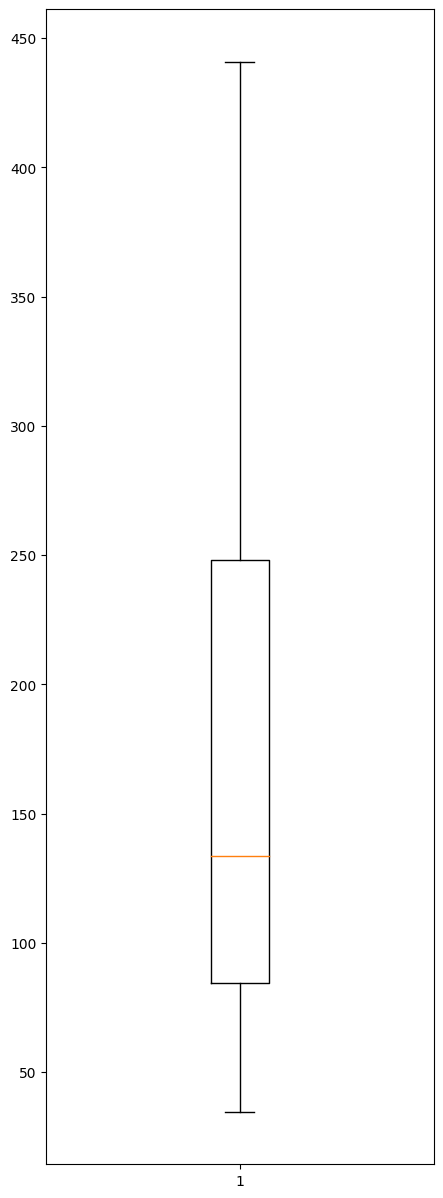

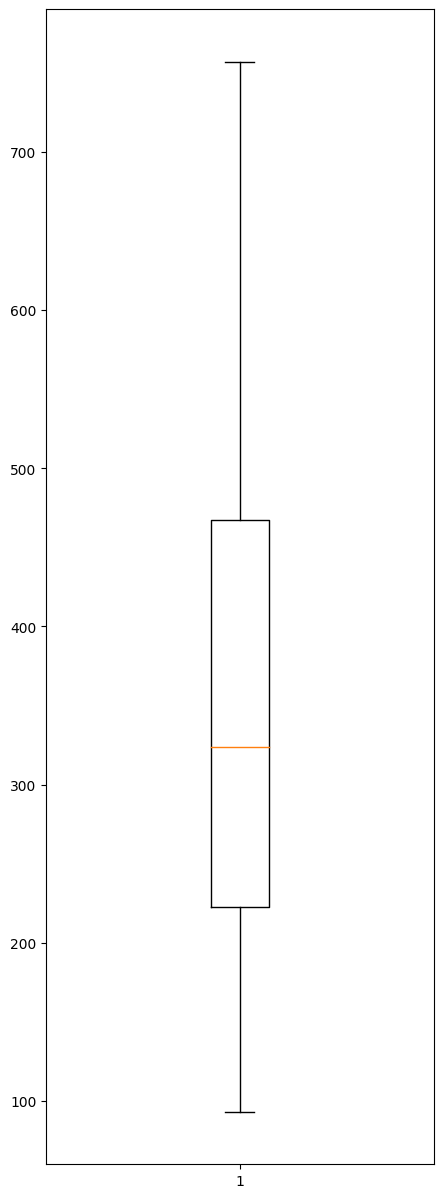

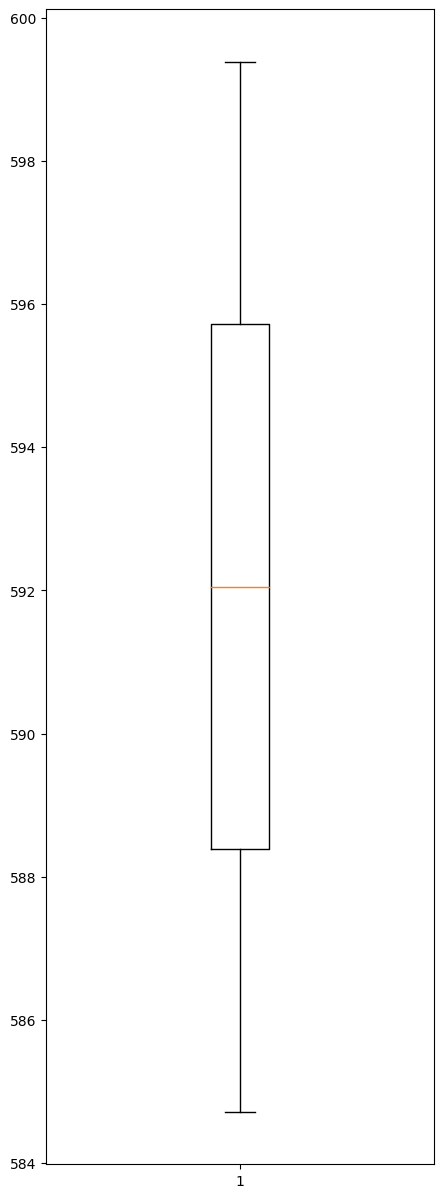

In [13]:
%matplotlib inline
for feature in list(data["ticket_type_nm"].unique()):
    fig, ax = plt.subplots(figsize=(5, 15))
    tu = data[data["ticket_type_nm"] == feature]
    B = ax.boxplot(tu["time_to_under"])
    


СК учащегося 30 дней
16177


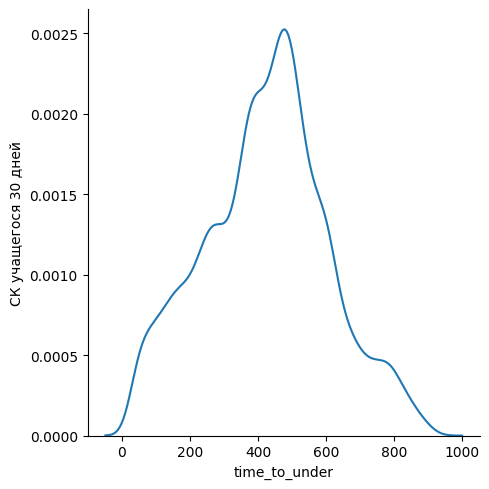

БСК дружинника г.Москвы
2692


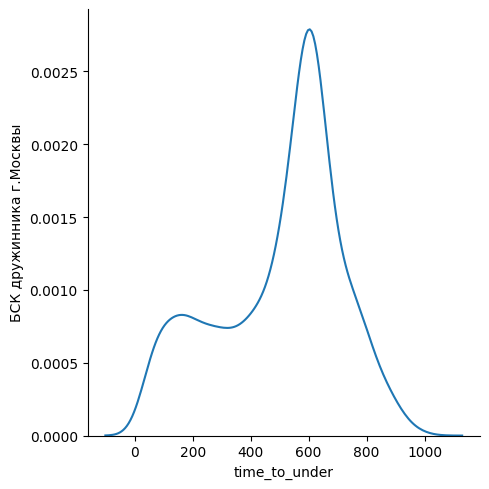

30 дней
112622


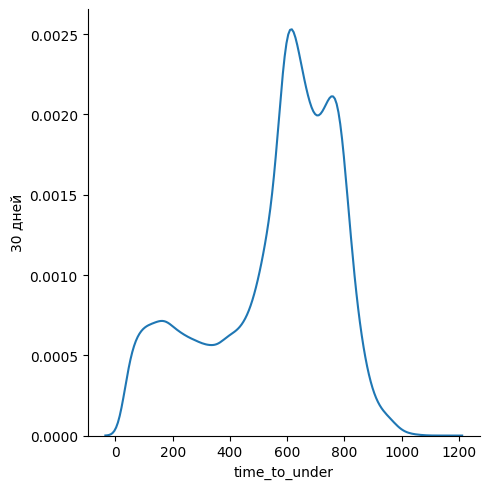

СК студента 30 дней
37134


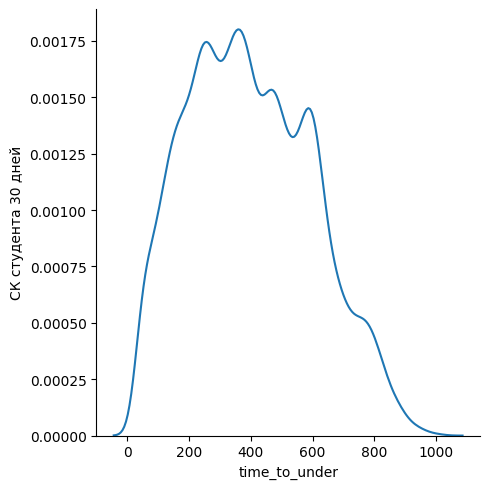

90 дней ЕДИНЫЙ ТК
56085


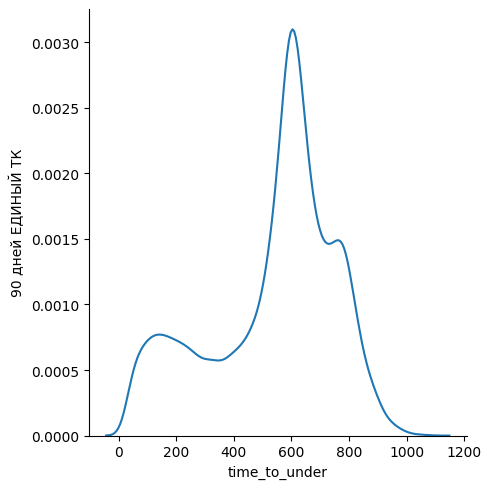

30 дней СК учащегося
23131


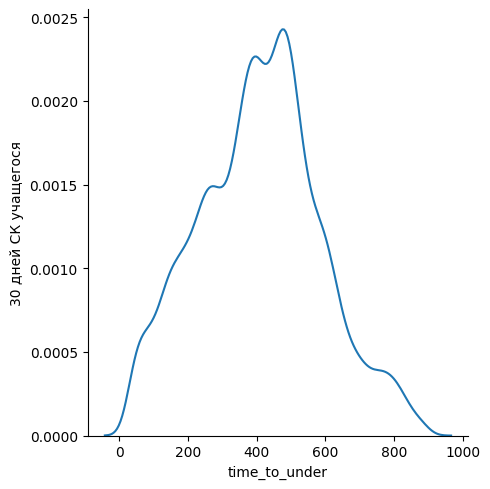

90 дней СК студента
2365


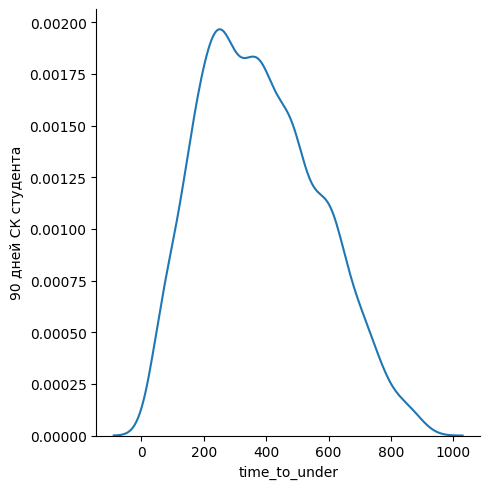

30 дней СК студента
45731


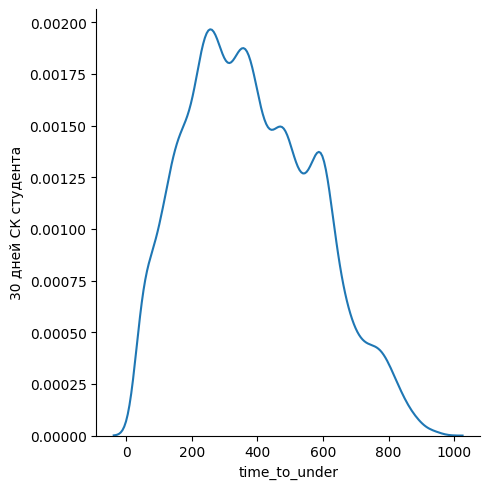

ББК
28168


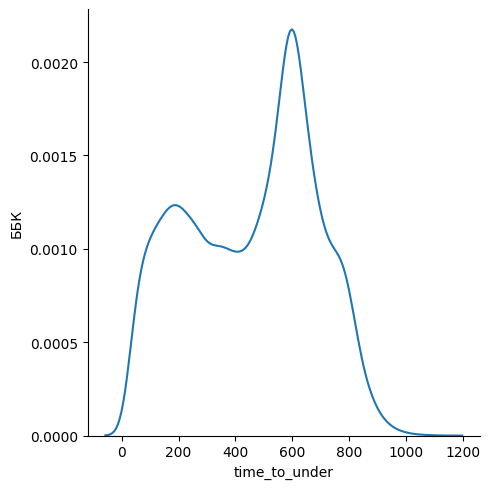

Войковская
7176


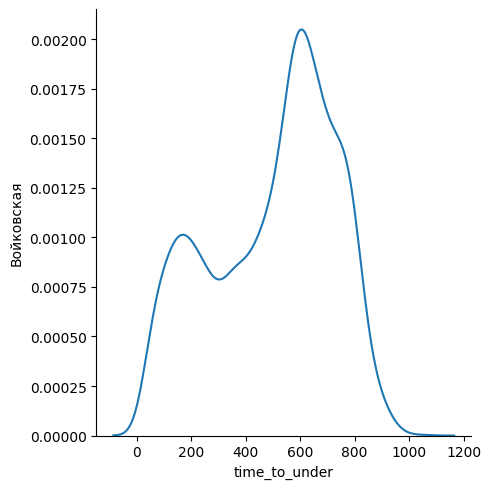

Аэропорт
4506


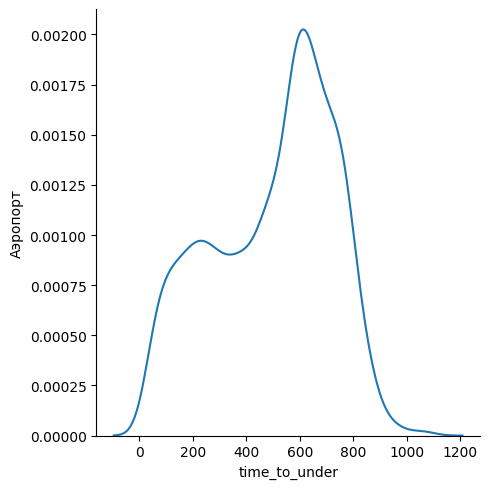

Косино
685


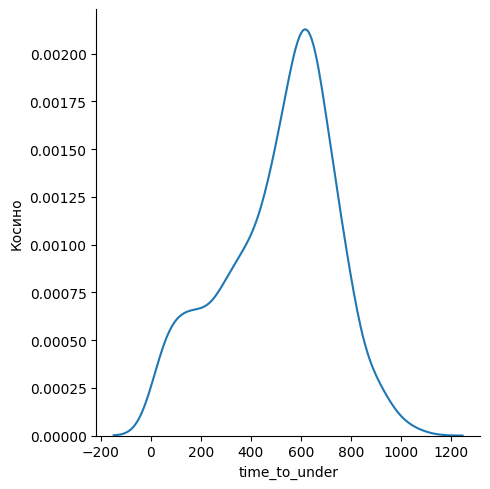

Котельники
11569


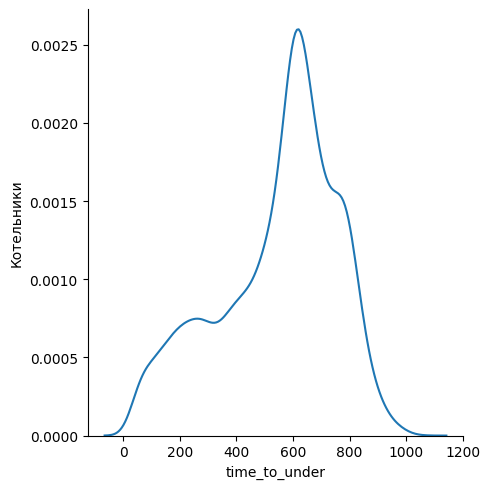

Сокол
3773


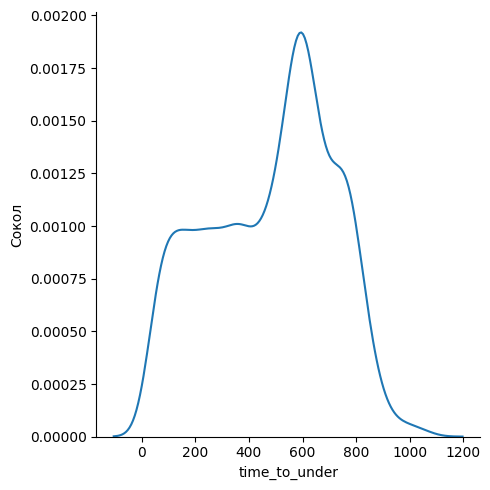

Новогиреево
17784


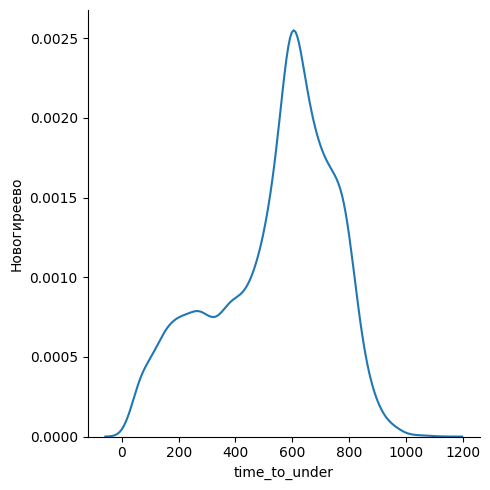

Кунцевская
6596


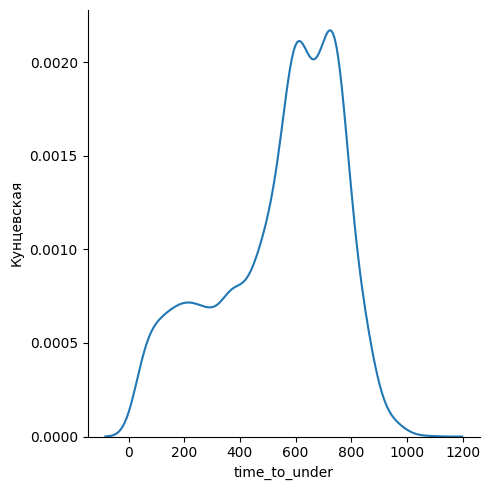

Проспект Вернадского
7214


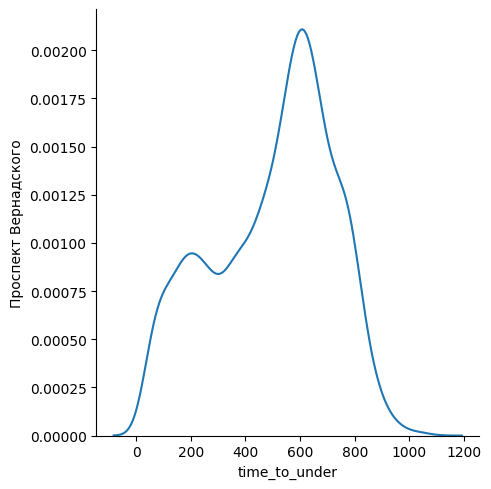

Динамо
2889


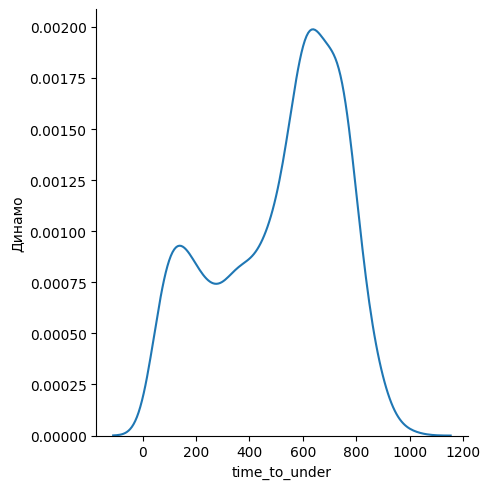

Замоскворецкая
117479


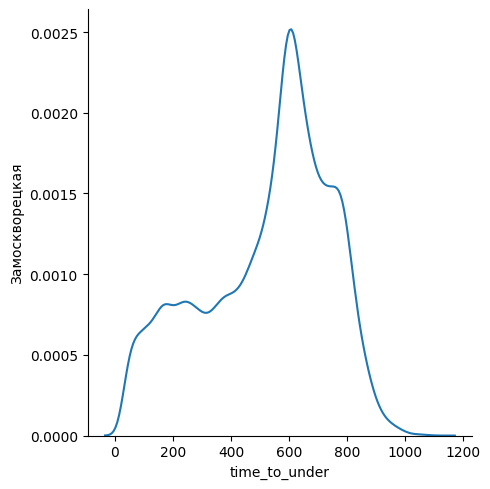

Некрасовская
29174


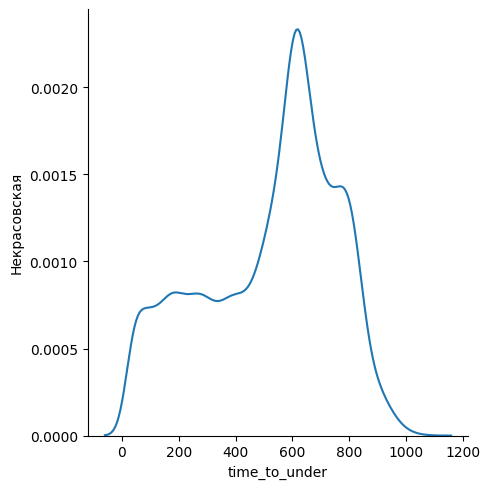

Таганско-Краснопресненская
146574


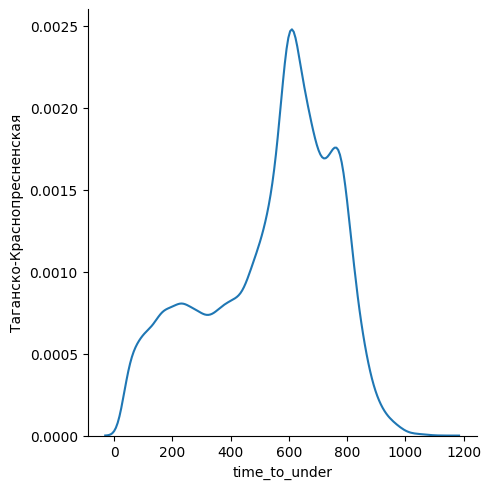

Калининская
58427


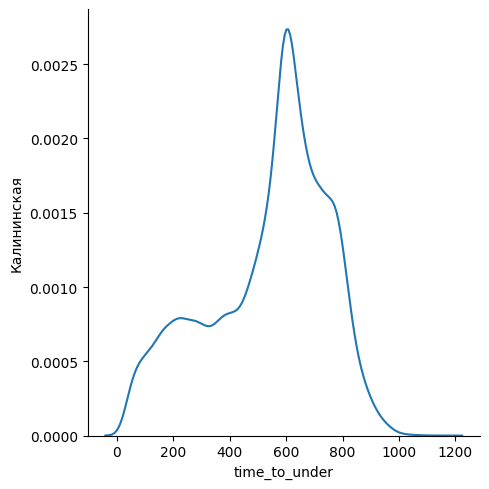

Арбатско-Покровская
105603


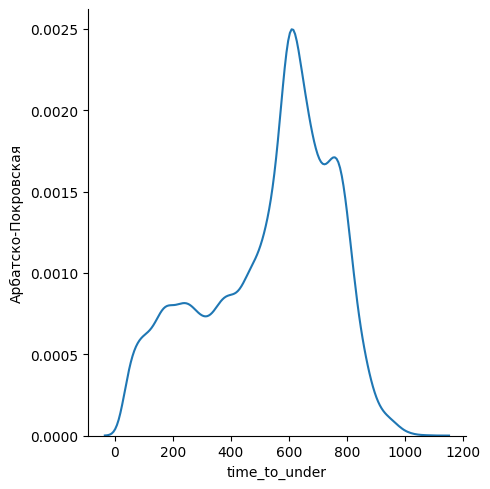

Сокольническая
76418


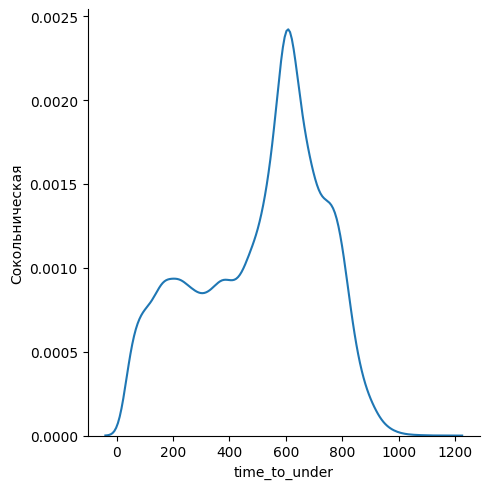

Серпуховско-Тимирязевская
115674


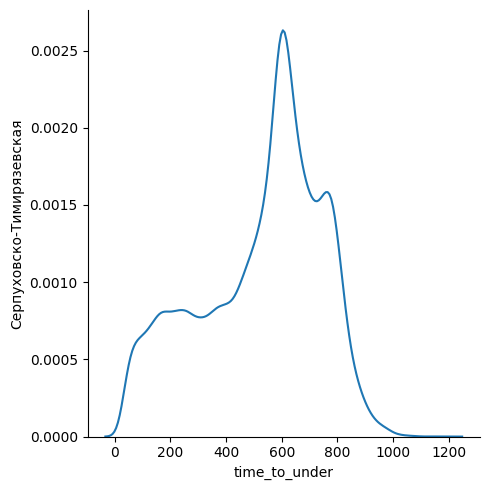

Люблинско-Дмитровская
90097


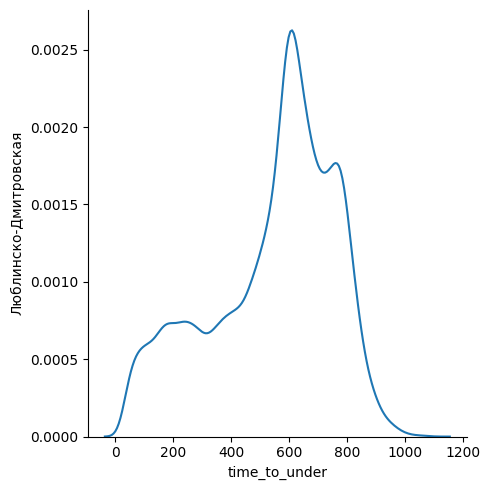

Кольцевая
29315


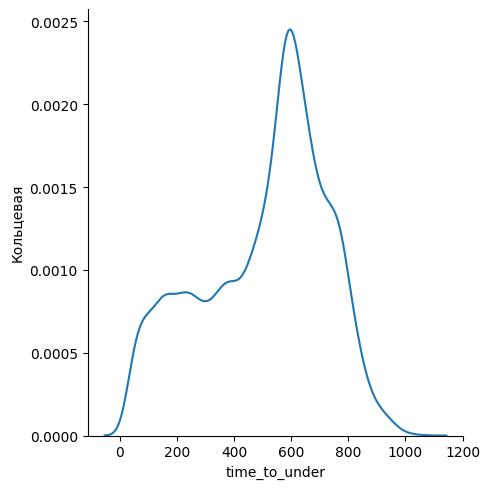

Войковская ( Южный )
5090


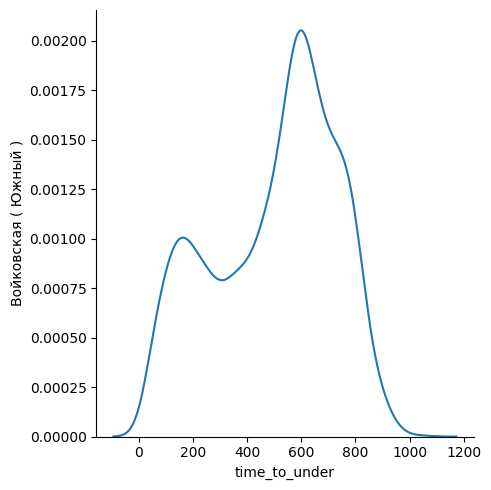

Аэропорт ( Северный )
3057


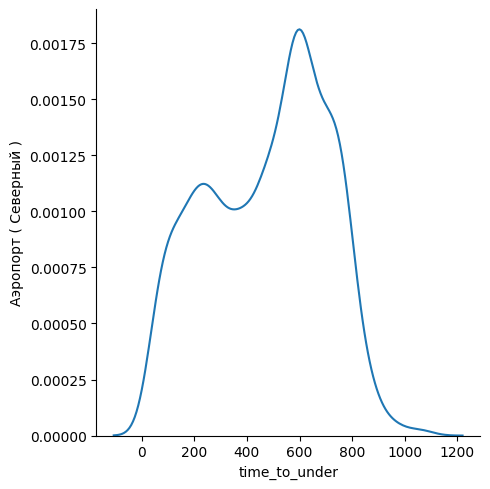

Косино (Первый)
153


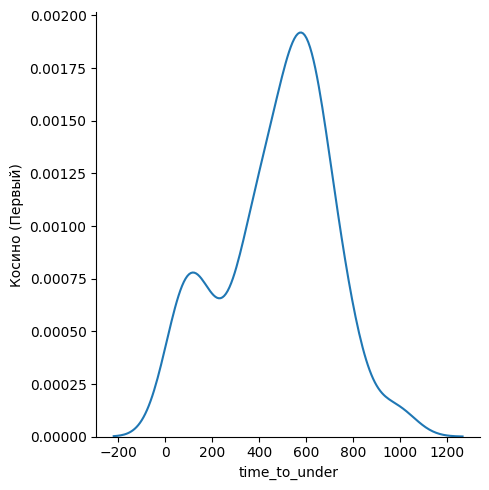

Котельники(Первый)
7291


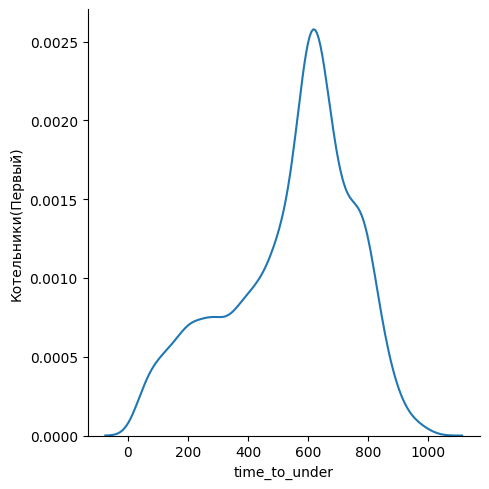

Сокол ( Южн./Вост. )
1423


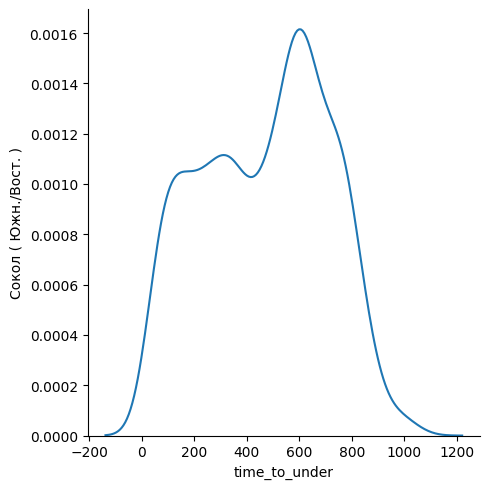

Новогиреево (Восточный)
11335


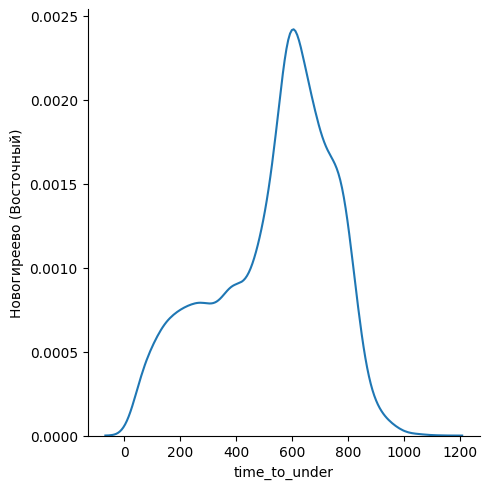

Кунцевская  (А-П) (Запад)
1015


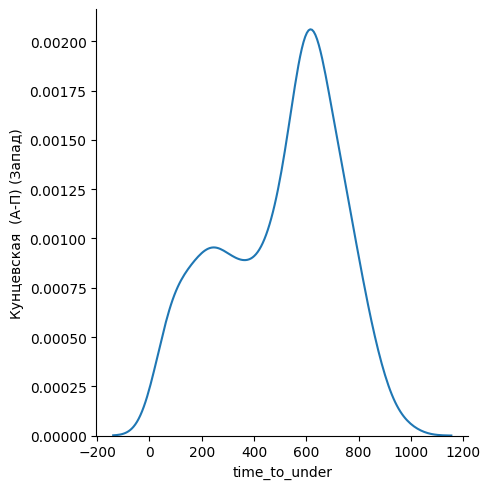

Проспект Вернадского ( Южный )
4225


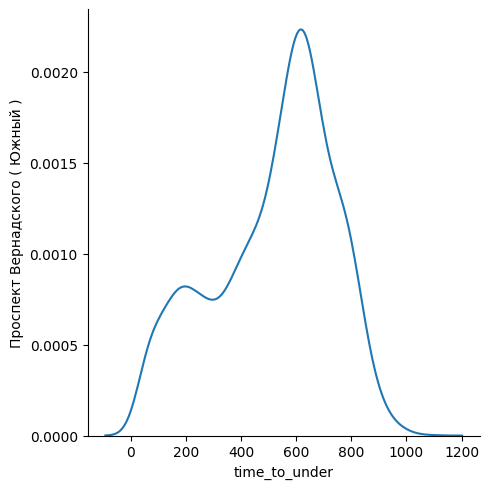

Динамо ( Северный )
1935


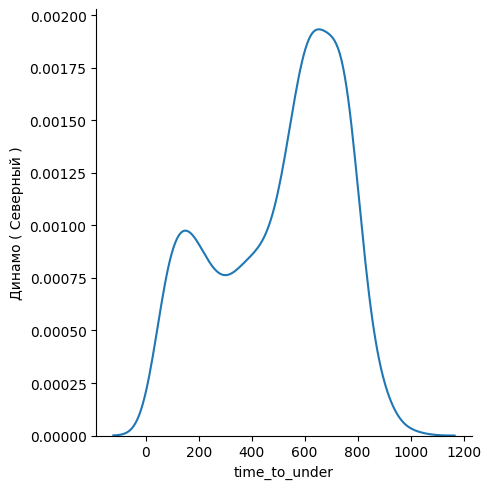

In [14]:
import seaborn as sns
%matplotlib inline

feature_groups = ["ticket_type_nm", "station_nm", "line_nm", "entrance_nm"]

for f_group in feature_groups:
    for feature in list(data[f_group].unique())[1:10]:
        d = data[data[f_group] == feature]["time_to_under"]
        print(feature)
        print(len(list(d)))

        fig = sns.displot(d, kind = "kde")
        fig.set_axis_labels('time_to_under', feature)
        plt.show()

#params = new_df


In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]


other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [other_items, categorical_features]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')
data_X = data[feature_names]
data_Y = data["time_to_under"]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y,
                                                    random_state=2, test_size = 0.3)

print("НАЧАЛО ОБУЧЕНИЯ")
regr = MLPRegressor(random_state=3, max_iter=30, hidden_layer_sizes=(100, 100, 100, 100)).fit(X_train, y_train)
print("КОНЕЦ ОБУЧЕНИЯ")


y_pred = regr.predict(X_test)

r2_sc = r2_score(y_test, y_pred)



print("РЕЗУЛЬТАТЫ: ")
print("mape: " + str(mape(y_pred, y_test)))
print("mse: " + str(mse(y_pred, y_test)))
print(r2_sc)

НАЧАЛО ОБУЧЕНИЯ


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


КОНЕЦ ОБУЧЕНИЯ
РЕЗУЛЬТАТЫ: 
mape: 0.24310752168516256
mse: 18261.13065569733
0.6210044349814718


In [16]:
len(data_X.columns.to_list())

752

In [24]:
r2_sc = 0.6222221395356518

Классификация нейронкой

In [18]:
data = data.dropna()

In [19]:
#[str(element) + " : " + str(data_Y.isin([element]).to_list().count(True)) for element in data_Y.unique()]

INDEX = []
labels = []
data_Y = data["label"]

for element in data_Y.unique():
    if data['label'].to_list().count(element) < 1000:
        ind = data[data["label"] == element].index.to_list();
        INDEX += ind;
        labels += [element];
        
data.drop(index = INDEX, inplace = True)
print(labels);


[15001, 11007, 1026, 10023, 12002, 14021, 14002, 14017, 10014, 1025, 14010, 14015, 1024, 2002, 14012, 14031, 14026, 81010, 4011, 10001, 15006, 14013, 4006, 81014, 10008, 14028, 15007, 12005, 15003, 14023, 4009, 15004, 11011, 14008, 14001, 6012, 12001, 14004, 13005, 13001, 13004, 13003, 13002, 13006]


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]

other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [categorical_features, other_items]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')

data_X = data[feature_names]
data_Y = data["label"]


X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y,
                                                    random_state=11, test_size = 0.1, stratify = data_Y)
print("НАЧАЛО ОБУЧЕНИЯ")
clf = DecisionTreeClassifier(max_depth=100, 
                           random_state=1).fit(X_train, y_train)

print("КОНЕЦ ОБУЧЕНИЯ")

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred, average='micro')
print("recall = ", recall)

print(classification_report(y_pred, y_test))

НАЧАЛО ОБУЧЕНИЯ
КОНЕЦ ОБУЧЕНИЯ
recall =  0.1140560066813576
              precision    recall  f1-score   support

        1002       0.09      0.09      0.09       268
        1003       0.11      0.10      0.11       319
        1004       0.08      0.07      0.08       271
        1005       0.12      0.11      0.12       498
        1006       0.10      0.10      0.10       588
        1007       0.09      0.08      0.08       690
        1008       0.09      0.09      0.09       606
        1009       0.10      0.10      0.10      1267
        1011       0.11      0.10      0.10       651
        1012       0.08      0.07      0.08       421
        1013       0.13      0.11      0.12       338
        1014       0.11      0.10      0.10       426
        1015       0.12      0.10      0.11       614
        1016       0.10      0.10      0.10       602
        1017       0.06      0.06      0.06       282
        1018       0.15      0.14      0.14       915
        1019       0.

In [23]:
recall = recall_score(y_test, y_pred, average='micro')
recall

0.1140560066813576

 accuracy                           0.08    422774
   macro avg       0.06      0.15      0.07    422774
weighted avg       0.26      0.08      0.09    422774






In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

new_features = ["Arts & Entertainment", "College & University",
                "Food", "Nightlife Spot", "Outdoors & Recreation", "Professional & Other Places", "Residence",
               "Shop & Service", "Travel & Transport"]

other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

other_items = ['entrance_minute', 'time_to_under', 'label', "holiday", "hour", "is_friday", "weekday"]

big2d_list = [categorical_features, other_items]

feature_names = [item for sublist in big2d_list for item in sublist]
feature_names.remove('label')
feature_names.remove('time_to_under')

data_X = data[feature_names]
data_Y = data["label"]


X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y,
                                                    random_state=11, test_size = 0.1, stratify = data_Y)
print("НАЧАЛО ОБУЧЕНИЯ")
clf = MLPClassifier(random_state = 1, hidden_layer_sizes=(300,300,300,300,300)).fit(X_train, y_train)

print("КОНЕЦ ОБУЧЕНИЯ")

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred, average='micro')
print("recall = ", recall)

print(classification_report(y_pred, y_test))

НАЧАЛО ОБУЧЕНИЯ


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


КОНЕЦ ОБУЧЕНИЯ


KeyboardInterrupt: 

In [ ]:
recall = recall_score(y_test, y_pred, average='micro')
recall

In [25]:
result = 0.5 * recall + 0.5 * r2_sc
result

0.3681390731085047